# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

# PATHS

In [2]:
path_data = Path('./input')

In [3]:
path_plots = Path('./plots')

# PLOTS

In [4]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

cm=1/2.54

# DATA

In [5]:
input_filename = path_data / 'clean_data.gz'
data = pd.read_csv(input_filename, 
                   compression=dict(method='gzip'),
                   index_col='index',
                   dtype={#'store_nbr': 'category',
                          'dayname': 'category',
                         },
                   parse_dates=['date'],
                   infer_datetime_format=True,
                  ) 
data['date'] = pd.to_datetime(data['date'])
'''
csv I/O removes any categorical information (categories and ordering). 
Such info has to be re initialized, or stored in a hdf files
'''
listdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
liststore = list(range(1, 55))
# pd.Categorical() to set the order according to the 'days' list
data.dayname = pd.Categorical(data.dayname, categories=listdays, ordered=True)
data.store_nbr = pd.Categorical(data.store_nbr, categories=liststore, ordered=True)
data['dayofmonth'] = data.date.dt.day

/tmp/ipykernel_303737/1249342532.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_filename,


In [6]:
# load transactions data
transactions = pd.read_csv(
    path_data / 'transactions.csv',
    usecols=['date', 'store_nbr', 'transactions'],
    dtype={'transactions': 'float32',
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

transactions['date'] = pd.to_datetime(transactions['date'])
transactions.store_nbr = pd.Categorical(transactions.store_nbr, categories=liststore, ordered=True)

In [7]:
# load oil price data
oil = pd.read_csv(
    path_data / 'oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
    )
oil.rename(columns = {'dcoilwtico' : 'price_oil'}, inplace = True)

oil['date'] = pd.to_datetime(oil['date'])

# FUNCTIONS

In [8]:
def save_multi_image(filename):
    
    # save numerous open figures into a single, multipage, pdf file
    
    from matplotlib.backends.backend_pdf import PdfPages

    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

In [9]:
def heatmap(piv, xlab, ylab, title, path, filename, cm):
    # piv: pandas pivot table
    # xlab, ylab, title: text as x/y label & title
    # path, filename: to store the figure
    # cm: fig size in cm
    
    fig = plt.figure(figsize=(18*cm, 18*cm))
    
    # mask the upper triangle of the pivot table
    mask = np.triu(piv.corr())
    
    ax = sns.heatmap(piv,
                     annot=False, # True would annotate the values in each individual cell
                     fmt='.1f',
                     cmap='Spectral_r',
                     square=True,
                     mask=mask,
                     linewidths=1,
                     cbar=True,
                     cbar_kws={'location': 'right', 'orientation': 'vertical', 'fraction': 0.025, 'aspect': 30},
                    )
    ax.set(xlabel=xlab, ylabel=ylab, title=title)
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [10]:
def weekly_mean_plot(df, group, col, xlab, ylab, title, legend_title, path, filename, cm):
    
    # df: dataframe. must contain the columns: 'group', 'dayname' and the relevant 'col' column to plot 
    # group: the df column one wants to groupby
    # col: the df column one wants to investigate
    # 'dayname' must be categorical and sorted
    
    temp = df.groupby([str(group), 'dayname'])[col].mean().reset_index().copy()

    df_wide = temp.pivot(index='dayname', columns=str(group), values=col)
    
    
    fig = plt.figure(figsize=(18*cm, 12*cm))
    
    ax = sns.lineplot(data=df_wide, palette='tab20')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    
    ax.legend(title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [11]:
def monthly_mean_plot(df, group, col, xlab, ylab, title, legend_title, path, filename, cm):
    
    # df: dataframe. must contain the columns: 'group', 'dayname' and the relevant 'col' column to plot 
    # group: the df column one wants to groupby
    # col: the df column one wants to investigate
    # 'dayofmonth' : self-explanatory
    
    temp = df.groupby([str(group), 'dayofmonth'])[col].mean().reset_index().copy()

    df_wide = temp.pivot(index='dayofmonth', columns=str(group), values=col)
        
    fig = plt.figure(figsize=(18*cm, 12*cm))
    
    ax = sns.lineplot(data=df_wide, palette='tab20')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    ax.legend(title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [12]:
def barploth(df, group, col, xlab, ylab, title, path, filename, cm):

    # df: dataframe. must contain the columns: group, and col
    # group: the df column one wants to groupby
    # col: the df column one wants to investigate
    
    temp = df.groupby(by=[str(group)])[str(col)].sum().reset_index().sort_values(by=[str(col)], ascending=True).copy()

    fig = plt.figure(figsize=(18*cm, 12*cm))
    
    ax=sns.barplot(data=temp, x=str(col), y=str(group), orient='h', palette='mako')
    # horizontal orientation makes it easier to deal with labels
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

# INVESTIGATING STORES

store_nbr       1       2      3       4         5      6            7  \
ind                                                                      
1             0.0     8.0    1.0     6.0   274.830   47.0   737.389000   
2          2293.0     0.0  367.0     0.0   133.000   22.0   225.252990   
3            33.0  2371.0   24.0     3.0   226.384    5.0  5946.388000   
4             0.0   222.0   15.0  3780.0  3983.000  315.0     0.000000   
5            20.0     9.0    3.0     0.0    51.000   20.0    86.076004   

store_nbr        8       9       10  ...        45     46        47      48  \
ind                                  ...                                      
1             8.00  5069.0    2.000  ...  3455.000  113.0   986.000     0.0   
2             0.00     0.0    1.000  ...  3692.000    4.0    40.000    17.0   
3            10.00   707.0    0.000  ...   961.031  886.0    35.000  7417.0   
4             0.00    40.0  137.009  ...   571.000   87.0  1684.396     0.0   
5      

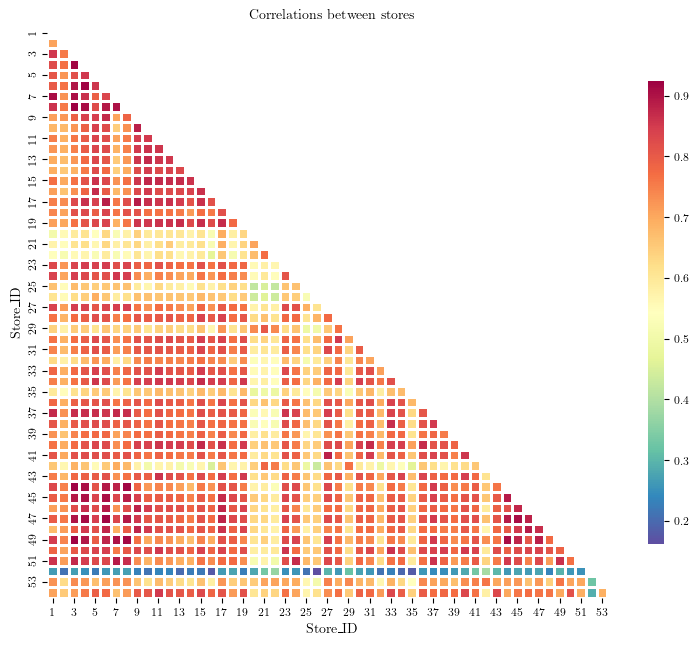

In [13]:
# create pivot table
df_store_nbr = data.loc[:,['store_nbr', 'sales']].copy()
# create an index increasing per entry of 'store_nbr'
# this new index will be used to reshape df_store_nbr via df.pivot
df_store_nbr['ind'] = 1
df_store_nbr['ind'] = df_store_nbr.groupby('store_nbr').ind.cumsum().values
print(df_store_nbr.pivot(index='ind', columns='store_nbr', values='sales').head())
# with such a df, it is possible to compute the correlation between stores
pivot_store_nbr = df_store_nbr.pivot(index='ind', columns='store_nbr', values='sales').corr()

# create heatmap
heatmap(pivot_store_nbr, r'Store\_ID', r'Store\_ID', r'Correlations between stores', path_plots, 'correlations_stores.pdf', cm)

# INVESTIGATING PRODUCTS

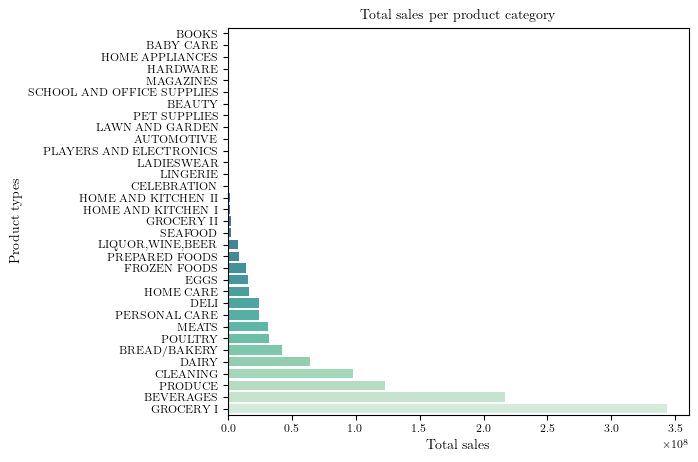

In [14]:
barploth(data, 'family', 'sales', r'Total sales', r'Product types', 'Total sales per product category', \
         path_plots, 'Total sales per product category.pdf', cm)

#### GROCERY I and BEVERAGES are the top-selling products

family  AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
ind                                                                     
1              0.0        0.0    10.0     7125.0    0.0      1269.480   
2              8.0        1.0     5.0     5069.0    0.0       707.000   
3             11.0        0.0     1.0     4753.0    0.0       784.683   
4             13.0        0.0     3.0     1905.0    0.0       230.000   
5             10.0        0.0     7.0     5204.0    0.0       776.350   

family  CELEBRATION  CLEANING   DAIRY     DELI  ...  MAGAZINES    MEATS  \
ind                                             ...                       
1              29.0    1686.0  2644.0  414.664  ...       23.0  566.128   
2              40.0    1054.0  1784.0  205.159  ...       42.0  594.222   
3              36.0    2603.0  1162.0  810.806  ...        3.0   60.519   
4              10.0    1377.0   293.0  243.000  ...       23.0  522.822   
5              18.0    1555.0  1561.0 

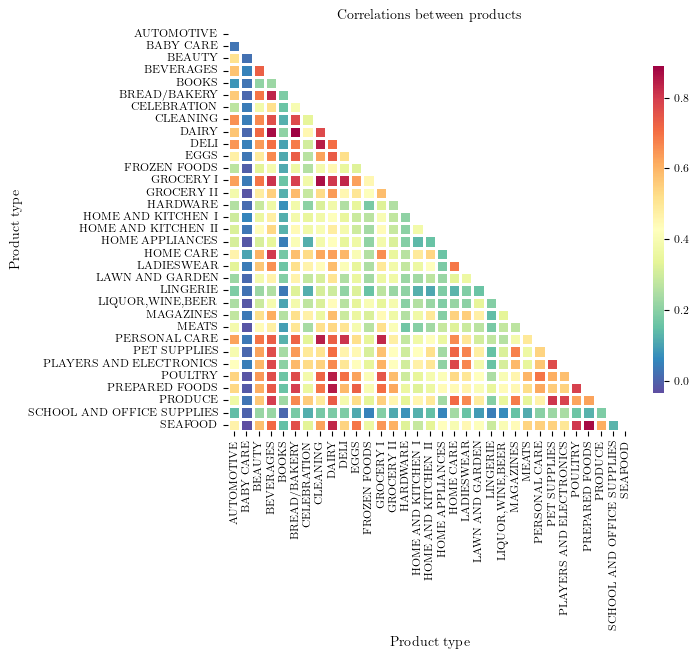

In [15]:
# create pivot table
df_products = data.loc[:,['family', 'sales']].copy()
df_products['ind'] = 1
df_products['ind'] = df_products.groupby('family').ind.cumsum().values
print(df_products.pivot(index='ind', columns='family', values='sales').head())
pivot_product = df_products.pivot(index='ind', columns='family', values='sales').corr()

# create heatmap
heatmap(pivot_product, r'Product type', r'Product type', r'Correlations between products', path_plots, 'correlations_products.pdf', cm)

#### In general product families are not very correlated
#### Some are totally uncorrelated with other products (BABY CARE, BOOKS, SCHOOL AND OFFICE SUPPLIES)
#### Some are strongly or very strongly correlated (GROCERY and BEVERAGES, PRODUCE and HOME CARE, LADIESWEAR and HOME CARE)

# INVESTIGATING SALES

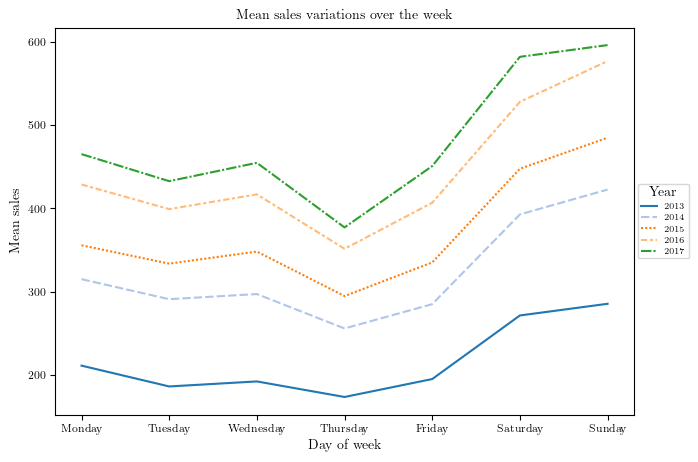

In [16]:
# total sales vs day of week\
weekly_mean_plot(data, 'year', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Year', path_plots, 'weekly_mean_sales_per_year.pdf', cm)    

#### Sales reach a minimum on Thursday, and are maximum over the weekend (no surprise here)

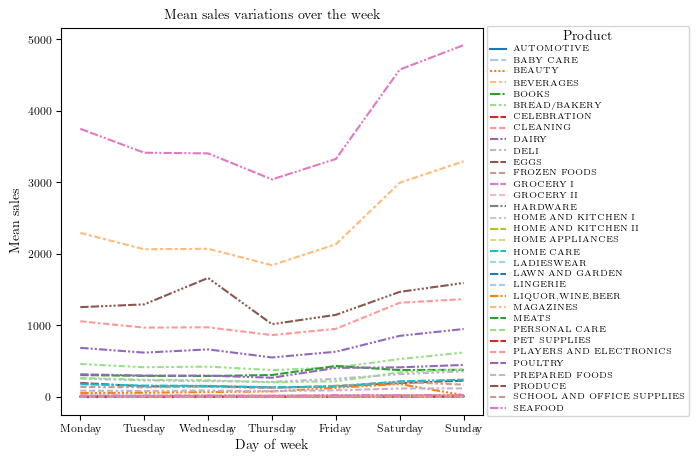

In [17]:
# product sales vs day of week
weekly_mean_plot(data, 'family', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Product', path_plots, 'weekly_mean_sales_per_product.pdf', cm)    

#### However this trend is driven by food products, in particular GROCERY I and BEVERAGES, which have the highest sales
#### Most of the other products do not show a specific trend over the week

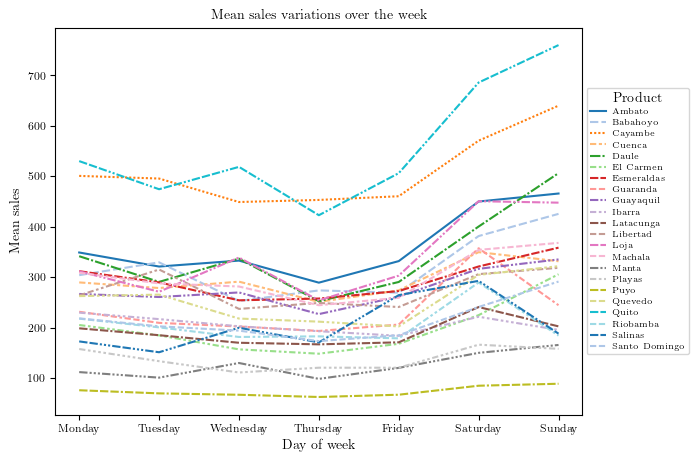

In [18]:
# total sales vs day of week, per city
weekly_mean_plot(data, 'city', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Product', path_plots, 'weekly_mean_sales_per_city.pdf', cm)    

#### The weekly trend varies from city to city (including a Wednesday peak and a (relative) Sunday drop for some.)

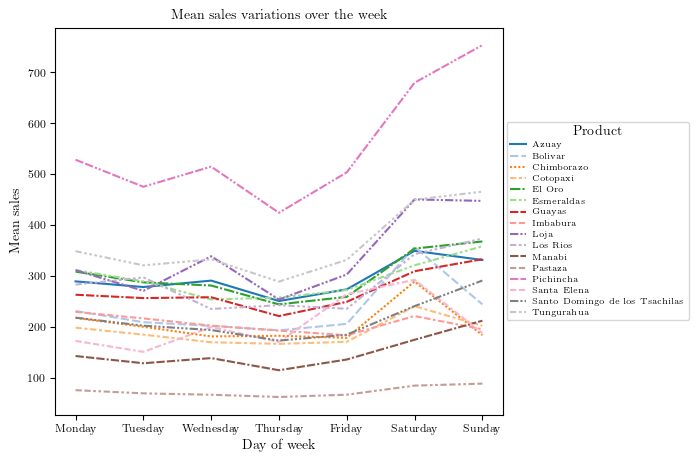

In [19]:
# total sales vs day of week, per state
weekly_mean_plot(data, 'state', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Product', path_plots, 'weekly_mean_sales_per_state.pdf', cm)   

#### Same as above for state trends

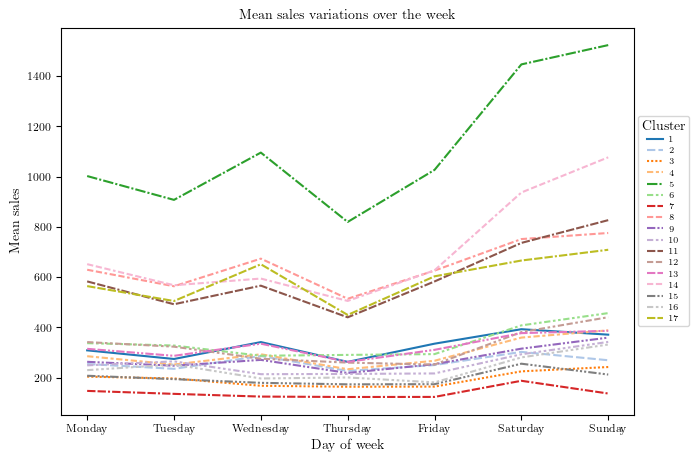

In [20]:
# total sales vs day of week, per cluster
weekly_mean_plot(data, 'cluster', 'sales', r'Day of week', r'Mean sales', r'Mean sales variations over the week', \
                 r'Cluster', path_plots, 'weekly_mean_sales_per_cluster.pdf', cm)   

#### Same as above for Cluster trends

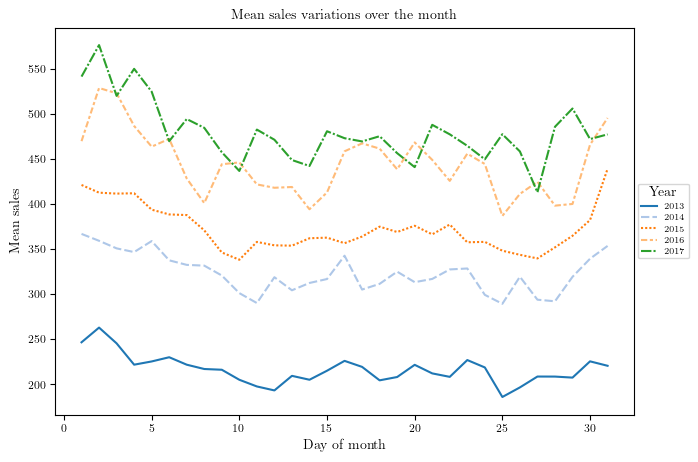

In [21]:
monthly_mean_plot(data, 'year', 'sales', r'Day of month', r'Mean sales', r'Mean sales variations over the month', \
                 r'Year', path_plots, 'monthly_mean_sales_per_year.pdf', cm)

#### Some increase of sales at the end of the month / beginning of the next month, after salaries have been paid, but the signal is week

# INVESTIGATING PROMOTIONS

In [22]:
# Pearson correlation coefficient
pearson_corr_prom=data.sales.corr(data.onpromotion, method='pearson')
print('Pearson correlation coefficient: {:,.4f}'.format(pearson_corr_prom))

Pearson correlation coefficient: 0.4279


In [23]:
# Spearman correlation coefficient
spearman_corr_prom=data.sales.corr(data.onpromotion, method='spearman')
print('Spearman correlation coefficient: {:,.4f}'.format(spearman_corr_prom))

Spearman correlation coefficient: 0.5380


In [24]:
def plot_scatter(x, y, xlab, ylab, title, legend_title, path, filename, cm):
    
    fig = plt.figure(figsize=(18*cm, 9*cm))
    ax = fig.add_subplot(111)
    
    ax.scatter(x, y, color='dodgerblue', s=1,)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

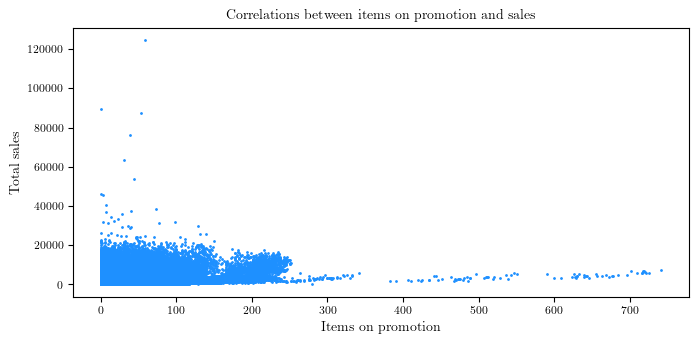

In [25]:
plot_scatter(data.onpromotion, data.sales, r'Items on promotion', r'Total sales', \
                'Correlations between items on promotion and sales', None, \
                path_plots, 'correlation_sales_promotions_global.pdf', cm)

#### No surprise here to see that promotions have a positive influence on sales

#### However, onpromotion is defined 'per family', so it is besser to investigate how various categories of products are sensitive to promotions. The definition says: 'onpromotion gives the total number of items in a product family that were being promoted at a store at a given date'.

In [26]:
temp_sales = data.groupby(["date", "family"]).sales.sum().reset_index()
sum_sales = temp_sales.pivot(index='date', columns='family', values='sales')
sum_sales.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01         0.0        0.0     2.0      810.0    0.0     180.58900   
2013-01-02       255.0        0.0   207.0    72092.0    0.0   26246.31900   
2013-01-03       161.0        0.0   125.0    52105.0    0.0   18456.48002   
2013-01-04       169.0        0.0   133.0    54167.0    0.0   16721.96901   
2013-01-05       342.0        0.0   191.0    77818.0    0.0   22367.76108   

family      CELEBRATION  CLEANING    DAIRY         DELI  ...  MAGAZINES  \
date                                                     ...              
2013-01-01          0.0     186.0    143.0     71.09000  ...        0.0   
2013-01-02          0.0   74629.0  23381.0  15754.50000  ...        0.0   
2013-01-03          0.0   55893.0  18001.0  11172.45500  ...        0.0   
2013-01-04          0.0   52064.0  18148.0  10143.20900  ...        0.0   
2013-01-05          0.0   70128.0  23082.0  13734.94501  ...        0.0   

family             MEATS  PERSONAL CARE  PET SUPPLIES  \
date                                                    
2013-01-01    110.801000           25.0           0.0   
2013-01-02  20871.464028        17204.0           0.0   
2013-01-03  16597.398113        12568.0           0.0   
2013-01-04  21625.963055        11303.0           0.0   
2013-01-05  20879.091050        16819.0           0.0   

family      PLAYERS AND ELECTRONICS       POULTRY  PREPARED FOODS  PRODUCE  \
date                                                                         
2013-01-01                      0.0     42.637000       37.847000      0.0   
2013-01-02                      0.0  13975.884938     5338.111976      0.0   
2013-01-03                      0.0  10674.393983     3591.388005      0.0   
2013-01-04                      0.0  10772.515038     4472.965990      0.0   
2013-01-05                      0.0  13475.009055     5830.073020      0.0   

family      SCHOOL AND OFFICE SUPPLIES      SEAFOOD  
date                                                 
2013-01-01                         0.0     0.000000  
2013-01-02                         0.0  1526.750002  
2013-01-03                         0.0  1094.310994  
2013-01-04                         0.0  1293.120995  
2013-01-05                         0.0  1245.637004  

[5 rows x 33 columns]

In [27]:
temp_prom = data.groupby(["date", "family"]).onpromotion.sum().reset_index()
sum_prom = temp_prom.pivot(index='date', columns='family', values='onpromotion')
sum_prom.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01           0          0       0          0      0             0   
2013-01-02           0          0       0          0      0             0   
2013-01-03           0          0       0          0      0             0   
2013-01-04           0          0       0          0      0             0   
2013-01-05           0          0       0          0      0             0   

family      CELEBRATION  CLEANING  DAIRY  DELI  ...  MAGAZINES  MEATS  \
date                                            ...                     
2013-01-01            0         0      0     0  ...          0      0   
2013-01-02            0         0      0     0  ...          0      0   
2013-01-03            0         0      0     0  ...          0      0   
2013-01-04            0         0      0     0  ...          0      0   
2013-01-05            0         0      0     0  ...          0      0   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2013-01-01              0             0                        0        0   
2013-01-02              0             0                        0        0   
2013-01-03              0             0                        0        0   
2013-01-04              0             0                        0        0   
2013-01-05              0             0                        0        0   

family      PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                      
2013-01-01               0        0                           0        0  
2013-01-02               0        0                           0        0  
2013-01-03               0        0                           0        0  
2013-01-04               0        0                           0        0  
2013-01-05               0        0                           0        0  

[5 rows x 33 columns]

In [28]:
def calc_corr(df1, df2, cat, method):
    return df1[cat].corr(df2[cat], method=method)

In [29]:
pearson_fam = []
spearman_fam = []
cat_list = data.family.unique()

for i, cat in enumerate(cat_list):
    pearson_fam.append(calc_corr(sum_sales, sum_prom, cat, 'pearson'))
    spearman_fam.append(calc_corr(sum_sales, sum_prom, cat, 'spearman'))

/home/lemasle/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [30]:
def plot_sales_prom_corr(cat_list, sp_list, pe_list, xlab, ylab, title, legend_title, path, filename, cm):
    
    fig = plt.figure(figsize=(12*cm, 18*cm))
    ax = fig.add_subplot(111)
    
    ax.scatter(sp_list, cat_list, color='dodgerblue', s=3, label='Spearman')
    ax.scatter(pe_list, cat_list, color='blue', s=3, label='Pearson')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab) 
    ax.set_title(title)
    ax.legend(loc='upper right', ncol=1,)
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

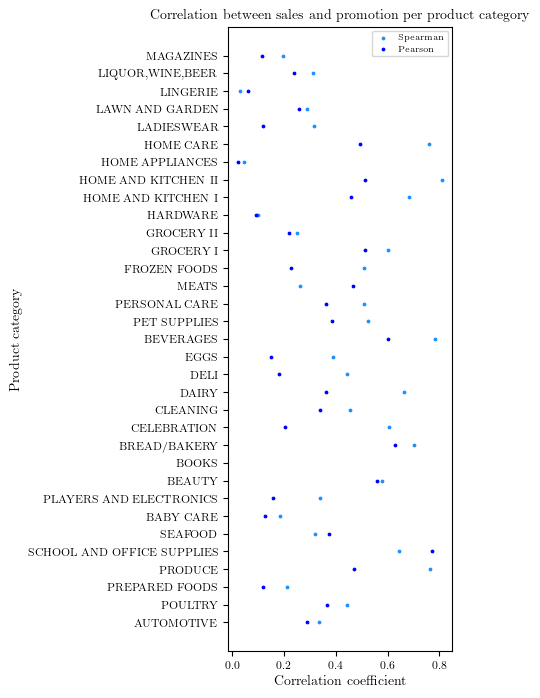

In [31]:
plot_sales_prom_corr(cat_list, spearman_fam, pearson_fam, 'Correlation coefficient', 'Product category',  \
                     'Correlation between sales and promotion per product category', 'Correlation', \
                     path_plots, 'correlation_sales_promotopn_per_family.pdf', cm)

#### We can look at an example with a rather high correlation between sales and promotions

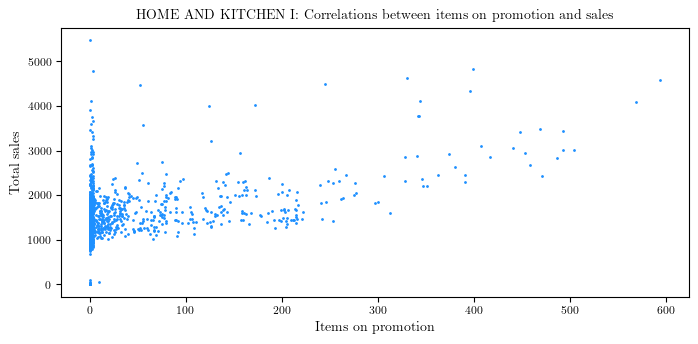

In [32]:
plot_scatter(sum_prom['HOME AND KITCHEN I'], sum_sales['HOME AND KITCHEN I'], r'Items on promotion', r'Total sales', \
                'HOME AND KITCHEN I: Correlations between items on promotion and sales', None, \
                path_plots, 'correlation_sales_promotions_HomeKitchen1.pdf', cm)

# Investigating transactions

In [33]:
temp = data.groupby(["date", "store_nbr"]).sales.sum().reset_index()
print(len(temp))
temp.head()

90936


date store_nbr  sales
0 2013-01-01         1    0.0
1 2013-01-01         2    0.0
2 2013-01-01         3    0.0
3 2013-01-01         4    0.0
4 2013-01-01         5    0.0

In [34]:
# merge sales grouped by date/store_nbr with transactions
transales = temp.merge(transactions, left_on=['date', 'store_nbr'], right_on=['date', 'store_nbr'], how='inner')
print(len(transales))
transales['year'] = transales.date.dt.year
transales['month'] = transales.date.dt.month
transales.head()

83488


date store_nbr         sales  transactions  year  month
0 2013-01-01        25   2511.618999         770.0  2013      1
1 2013-01-02         1   7417.148000        2111.0  2013      1
2 2013-01-02         2  10266.718981        2358.0  2013      1
3 2013-01-02         3  24060.348000        3487.0  2013      1
4 2013-01-02         4  10200.083980        1922.0  2013      1

In [35]:
# NOTE THAT SOME SHOPS HAVE O SALES FOR CONSECUTIVE (EARLY) DATES
# PROBABLY THESE SHOPS DID NOT EXIST YET AT THE BEGINNING OF THE EXPERIMENT

In [36]:
def multiyear_data(df, col, group, col_group, xlab, ylab, title, legend_title, path, filename, cm):

    # df: dataframe. must contain a 'date', a 'col', and a 'col_group' column
    # date: self explanatory
    # col: the df column one wants to investigate
    # col_group: the df column used to color code the output
    
    temp = df.groupby(by=[str(group), 'date'])[str(col)].sum().reset_index().copy()  # .sort_values(by=['date'], ascending=True).copy()
   
    fig = plt.figure(figsize=(25*cm, 18*cm))
    
    ax = sns.lineplot(data=df, x='date', y=str(col), hue=str(col_group), palette='tab20')

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend(ncol=3,
              title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1)
             )
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

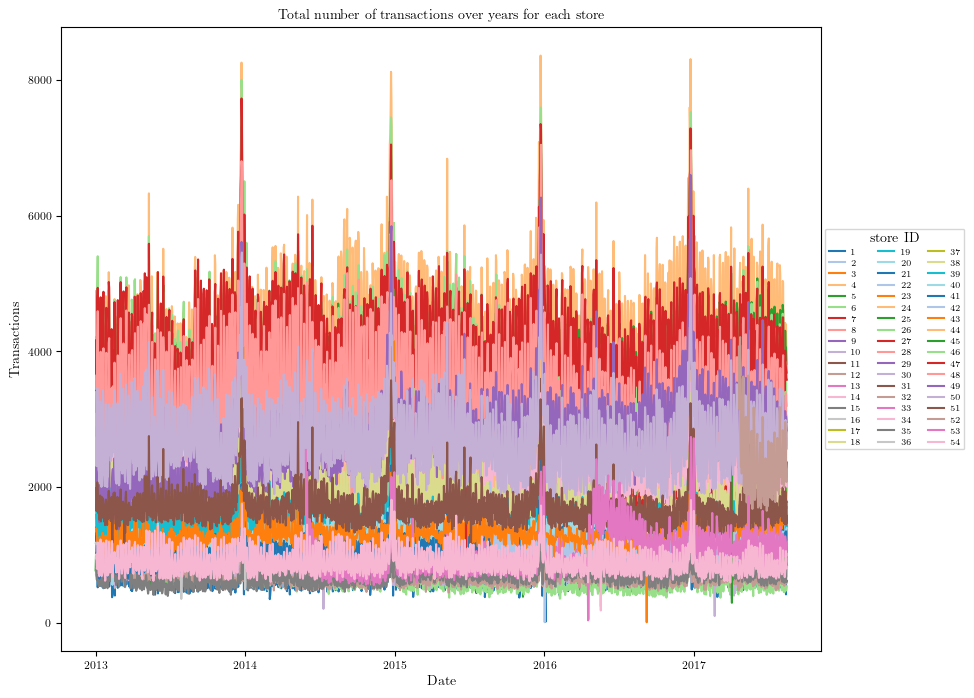

In [37]:
multiyear_data(transales, 'transactions', 'store_nbr', 'store_nbr', r'Date', r'Transactions', \
               r'Total number of transactions over years for each store', r'store ID', path_plots, \
               'transactions_per_store_over_years.pdf', cm)

#### There is a very clear pattern of strongly increased transactions at the end of the year period (Christmas period)

In [38]:
def multiyear_boxplot(df, coly, colhue, xlab, ylab, title, legend_title, path, filename, cm):

    # df: dataframe. must contain a 'date', a 'col', and a 'col_group' column
    # date: self explanatory
    # col: the df column one wants to investigate
    # col_group: the df column used to color code the output
    
   
    fig = plt.figure(figsize=(18*cm, 12*cm))
    
    ax = sns.boxplot(data=df, x='year', y=str(coly), hue=str(colhue), orient='v', palette='tab20', \
            saturation=0.75, width=0.8, dodge=True, showfliers=False, linewidth=None)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend(ncol=1,
              title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1)
             )
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [39]:
def plot_single_OLS(df, colx, coly, xlab, ylab, title, legend_title, path, filename, cm):
    
    fig = plt.figure(figsize=(18*cm, 9*cm))
       
    ax = sns.regplot(data=df, x=str(colx), y=str(coly), robust=False, \
                   scatter_kws = {'s': 1, 'color': 'dodgerblue',}, \
                   line_kws = {'lw': 2, 'color': 'royalblue',},
                   )

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

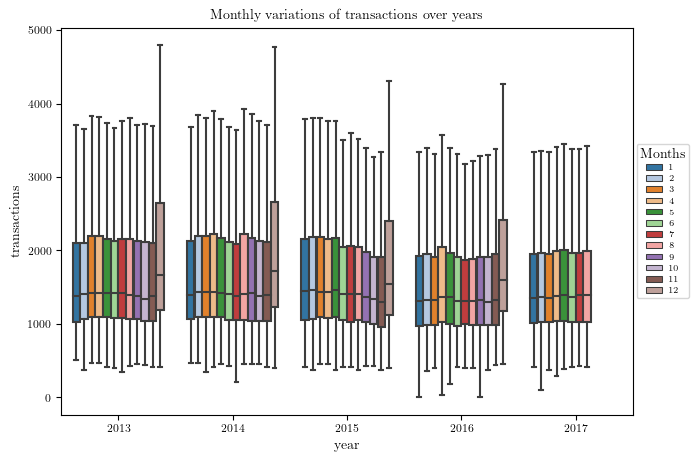

In [40]:
multiyear_boxplot(transales, 'transactions', 'month', r'year', r'transactions', \
            r'Monthly  variations of transactions over years', 'Months', path_plots, 'transactions_per_month_over_years.pdf', cm)

#### The same pattern can be seen on the boxplot

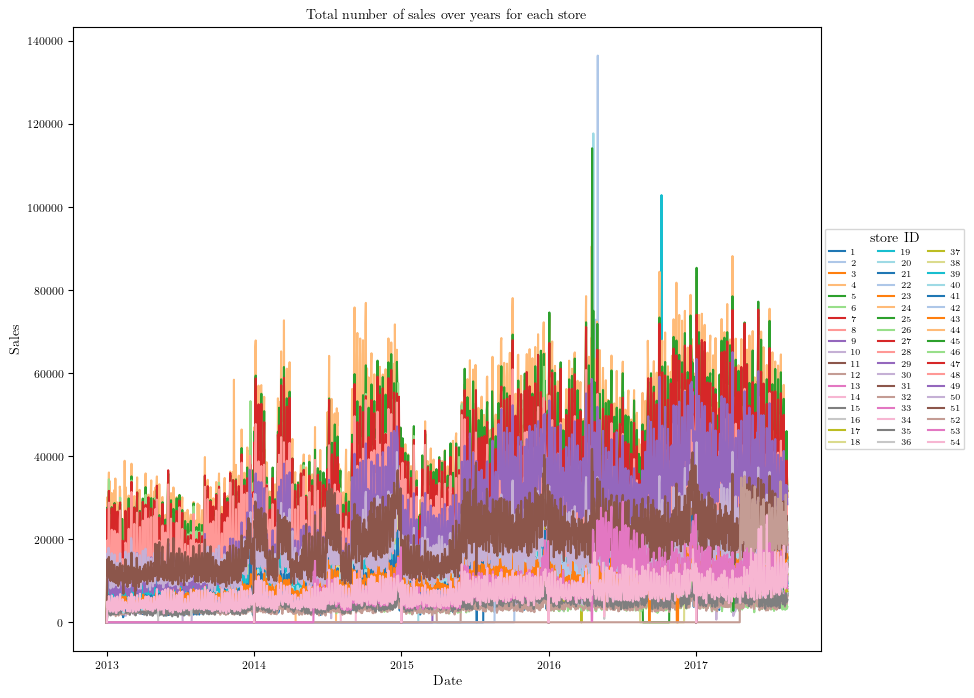

In [41]:
multiyear_data(temp, 'sales', 'store_nbr', 'store_nbr', r'Date', r'Sales', \
               r'Total number of sales over years for each store', r'store ID', path_plots, \
               'sales_per_store_over_years.pdf', cm)

#### This pattern is still present but not so clear when examining the number of sales per store on a multi-year basis

In [42]:
# Pearson correlation coefficient
pearson_corr=transales.sales.corr(transales.transactions, method='pearson')
print('Pearson correlation coefficient: {:,.4f}'.format(pearson_corr))

Pearson correlation coefficient: 0.8374


In [43]:
# Spearman correlation coefficient
spearman_corr=transales.sales.corr(transales.transactions, method='spearman')
print('Spearman correlation coefficient: {:,.4f}'.format(spearman_corr))

Spearman correlation coefficient: 0.8175


#### No surprise to see that sales and transactions are highly correlated

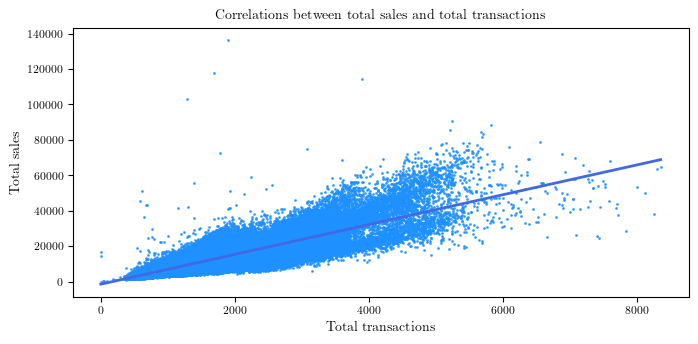

In [44]:
plot_single_OLS(transales, 'transactions', 'sales', r'Total transactions', r'Total sales', \
                'Correlations between total sales and total transactions', None, \
                path_plots, 'correlation_sales_transactions_global.pdf', cm)

#### And this can be seen on a scatter plot

In [45]:
def plot_multiple_OLS(df, colx, coly, colhue, xlab, ylab, title, legend_title, path, filename, cm):
    
    fg = plt.figure(figsize=(18*cm, 9*cm))
    
    fg = sns.lmplot(data=df, x=str(colx), y=str(coly), hue=str(colhue), robust=False, \
                    palette='tab20', 
                    scatter_kws = {'s': 1, },
                    line_kws = {'lw': 2, },
                    facet_kws = {'legend_out': True, },
                    ci=None,
                    legend=False,
                    truncate=True)

    fg.set_axis_labels(x_var=xlab, y_var=ylab)
    fg.set(xlim=(0, None), ylim=(0, None))
    fg.add_legend(title=legend_title) 
    sns.move_legend(fg, "center left", bbox_to_anchor= (1, 0, 0.5, 1), ncol=3)
    
    fg.tight_layout()
    file = path / str(filename)
    fg.savefig(file, format='pdf')    

<Figure size 708.661x354.331 with 0 Axes>

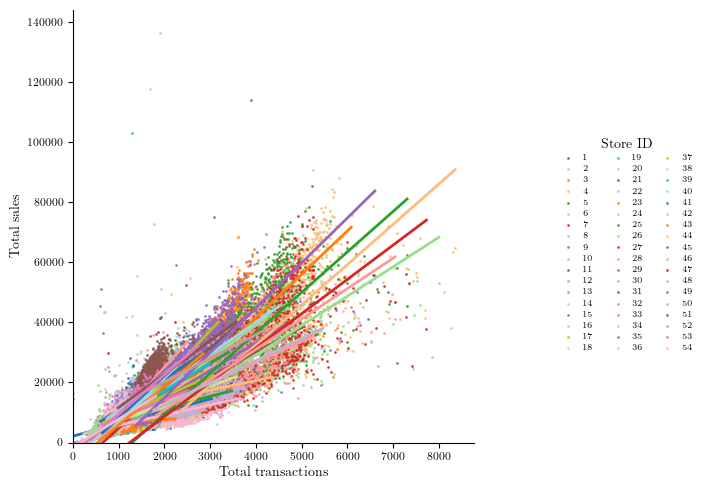

In [46]:
plot_multiple_OLS(transales, 'transactions', 'sales', 'store_nbr', r'Total transactions', r'Total sales', \
                  'Correlations between total sales and total transactions, per store', r'Store ID', \
                  path_plots, 'correlation_sales_transactions_per_store.pdf', cm)

#### as well as on a scatter plot for individual stores

In [47]:
# Add time information to the transactions df
transactions['dayname'] = transactions.date.dt.day_name()
transactions.dayname = pd.Categorical(transactions.dayname, categories=listdays, ordered=True)
transactions['dayofmonth'] = transactions.date.dt.day
transactions['month'] = transactions.date.dt.month
transactions['year'] = transactions.date.dt.year

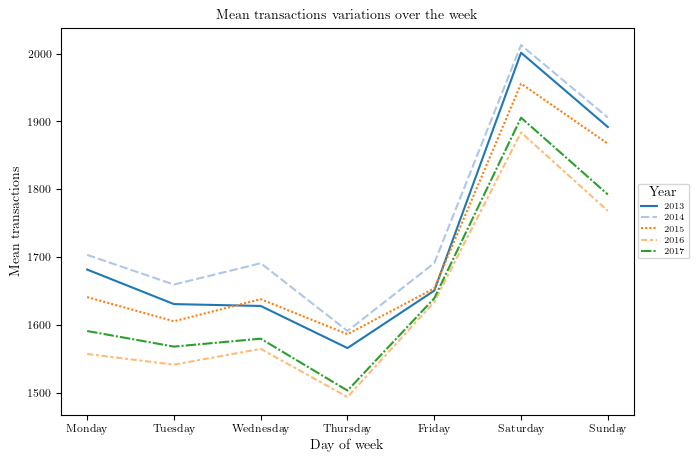

In [48]:
# total transactions vs day of week\
weekly_mean_plot(transactions, 'year', 'transactions', r'Day of week', r'Mean transactions', r'Mean transactions variations over the week', \
                 r'Year', path_plots, 'weekly_mean_transactions_per_year.pdf', cm)   

#### Same pattern as for sales, more transactions on the weekend (especially Saturdays, least of them on Thursdays)

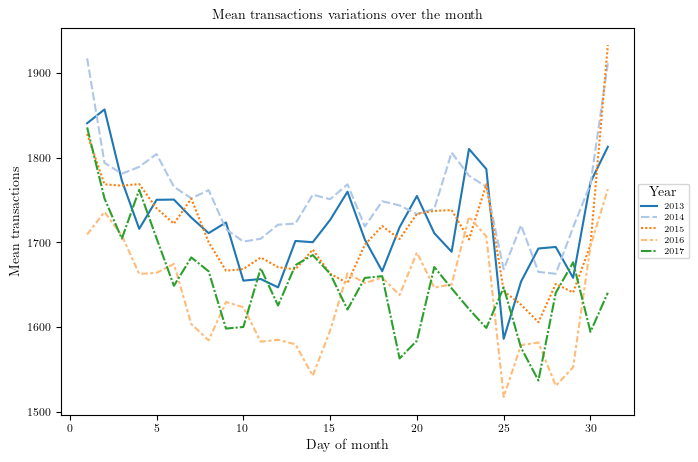

In [49]:
monthly_mean_plot(transactions, 'year', 'transactions', r'Day of month', r'Mean transactions', r'Mean transactions variations over the month', \
                 r'Year', path_plots, 'monthly_mean_transactions_per_year.pdf', cm)

#### Transactions are higher at the end of the month and the beginning of the next month, after salaries have been paid. Salaries are also paid at the mid-months, but this does not produce a strong signal in the transactions dats 

In [50]:
def plot_hist(df, col, binwidth, binrange, xlab, ylab, title, path, filename, cm):
    
    # df: dataframe. must contain a 'col' column to investigate
       
    fig = plt.figure(figsize=(9*cm, 9*cm))
    
    ax = sns.histplot(data=df, x=str(col), binwidth=binwidth, binrange=binrange, color='dodgerblue',
                      kde=True, line_kws={'lw': 2, 'color':'royalblue'}
                     )

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

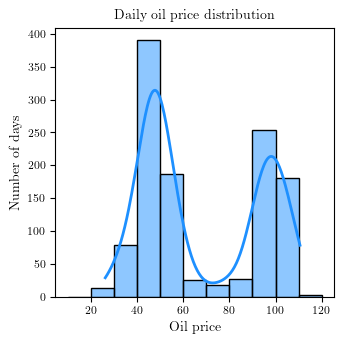

In [51]:
plot_hist(oil, 'price_oil', 10, (10,120), r'Oil price', r'Number of days', 'Daily oil price distribution', \
          path_plots, 'daily_oil_price_distribution.pdf', cm)

#### There are two different regimes for oil prices, a 'low' price around 45 and a 'high' price around 105

In [52]:
def time_evolution(df, col_list, label_list, xlab, ylab, title, path, filename, cm):
    
    import matplotlib.colors as mpc
    
    fig = plt.figure(figsize=(18*cm, 12*cm))
    ax = fig.add_subplot(111)
    
    cmap = plt.cm.get_cmap('tab20')
    colors = [mpc.to_hex(cmap(i)) for i in range(20)]
    
    for i in reversed(range(len(col_list))):
        ax.plot(df.date, df[str(col_list[i])], label = label_list[i], color=colors[i+1])
                
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
        
    ax.legend(#title=legend_title,
              loc="upper right",
              #bbox_to_anchor=(1, 0, 0.5, 1)
             )
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [53]:
# An initial plot of the time evolution of oil price shows missing data
# A quick and easy way to fill in the blanks is a linear interpolation
oil['price_oil_interp'] =oil.price_oil.interpolate()

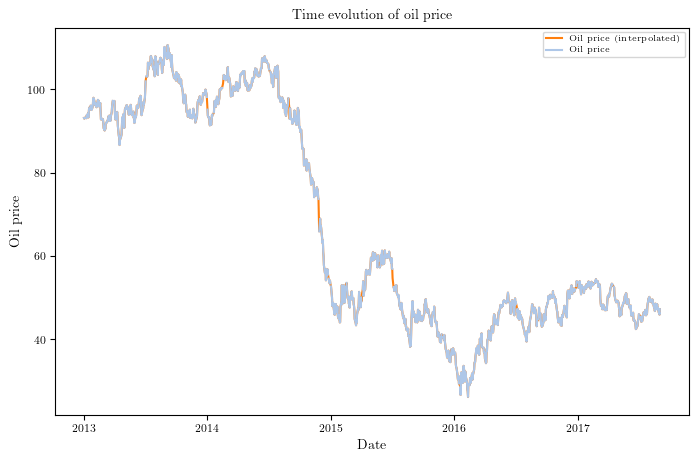

In [54]:
time_evolution(oil, ['price_oil','price_oil_interp'], ['Oil price', 'Oil price (interpolated)'], r'Date', r'Oil price', r'Time evolution of oil price', \
               path_plots, 'oil_price_time_evolution.pdf', cm)

#### The 'low' price around 45 and a 'high' price around 105 seem to correspond to the time periods 'after 2015' and 'before 2015'

In [55]:
temp = pd.merge(data.groupby(['date', 'family']).sales.sum().reset_index(), oil.drop('price_oil', axis = 1), how = 'left')

In [56]:
def multi_scatter(df, colx, coly, colgroup, ncols, xlab, ylab, path, filename, cm):

    fg = plt.figure(figsize=(18*cm, 18*cm))
    
    fg = sns.relplot(
        data=df, x=str(colx), y=str(coly),
        col=str(colgroup), col_wrap=ncols,
        facet_kws={'sharey': False},
        s=5, color='darkblue',
        kind="scatter",
        )

    fg.set_axis_labels(xlab, ylab)
    fg.set_titles(col_template='{col_name}')

    fg.tight_layout()
    file = path / str(filename)
    fg.savefig(file, format='pdf')

<Figure size 708.661x708.661 with 0 Axes>

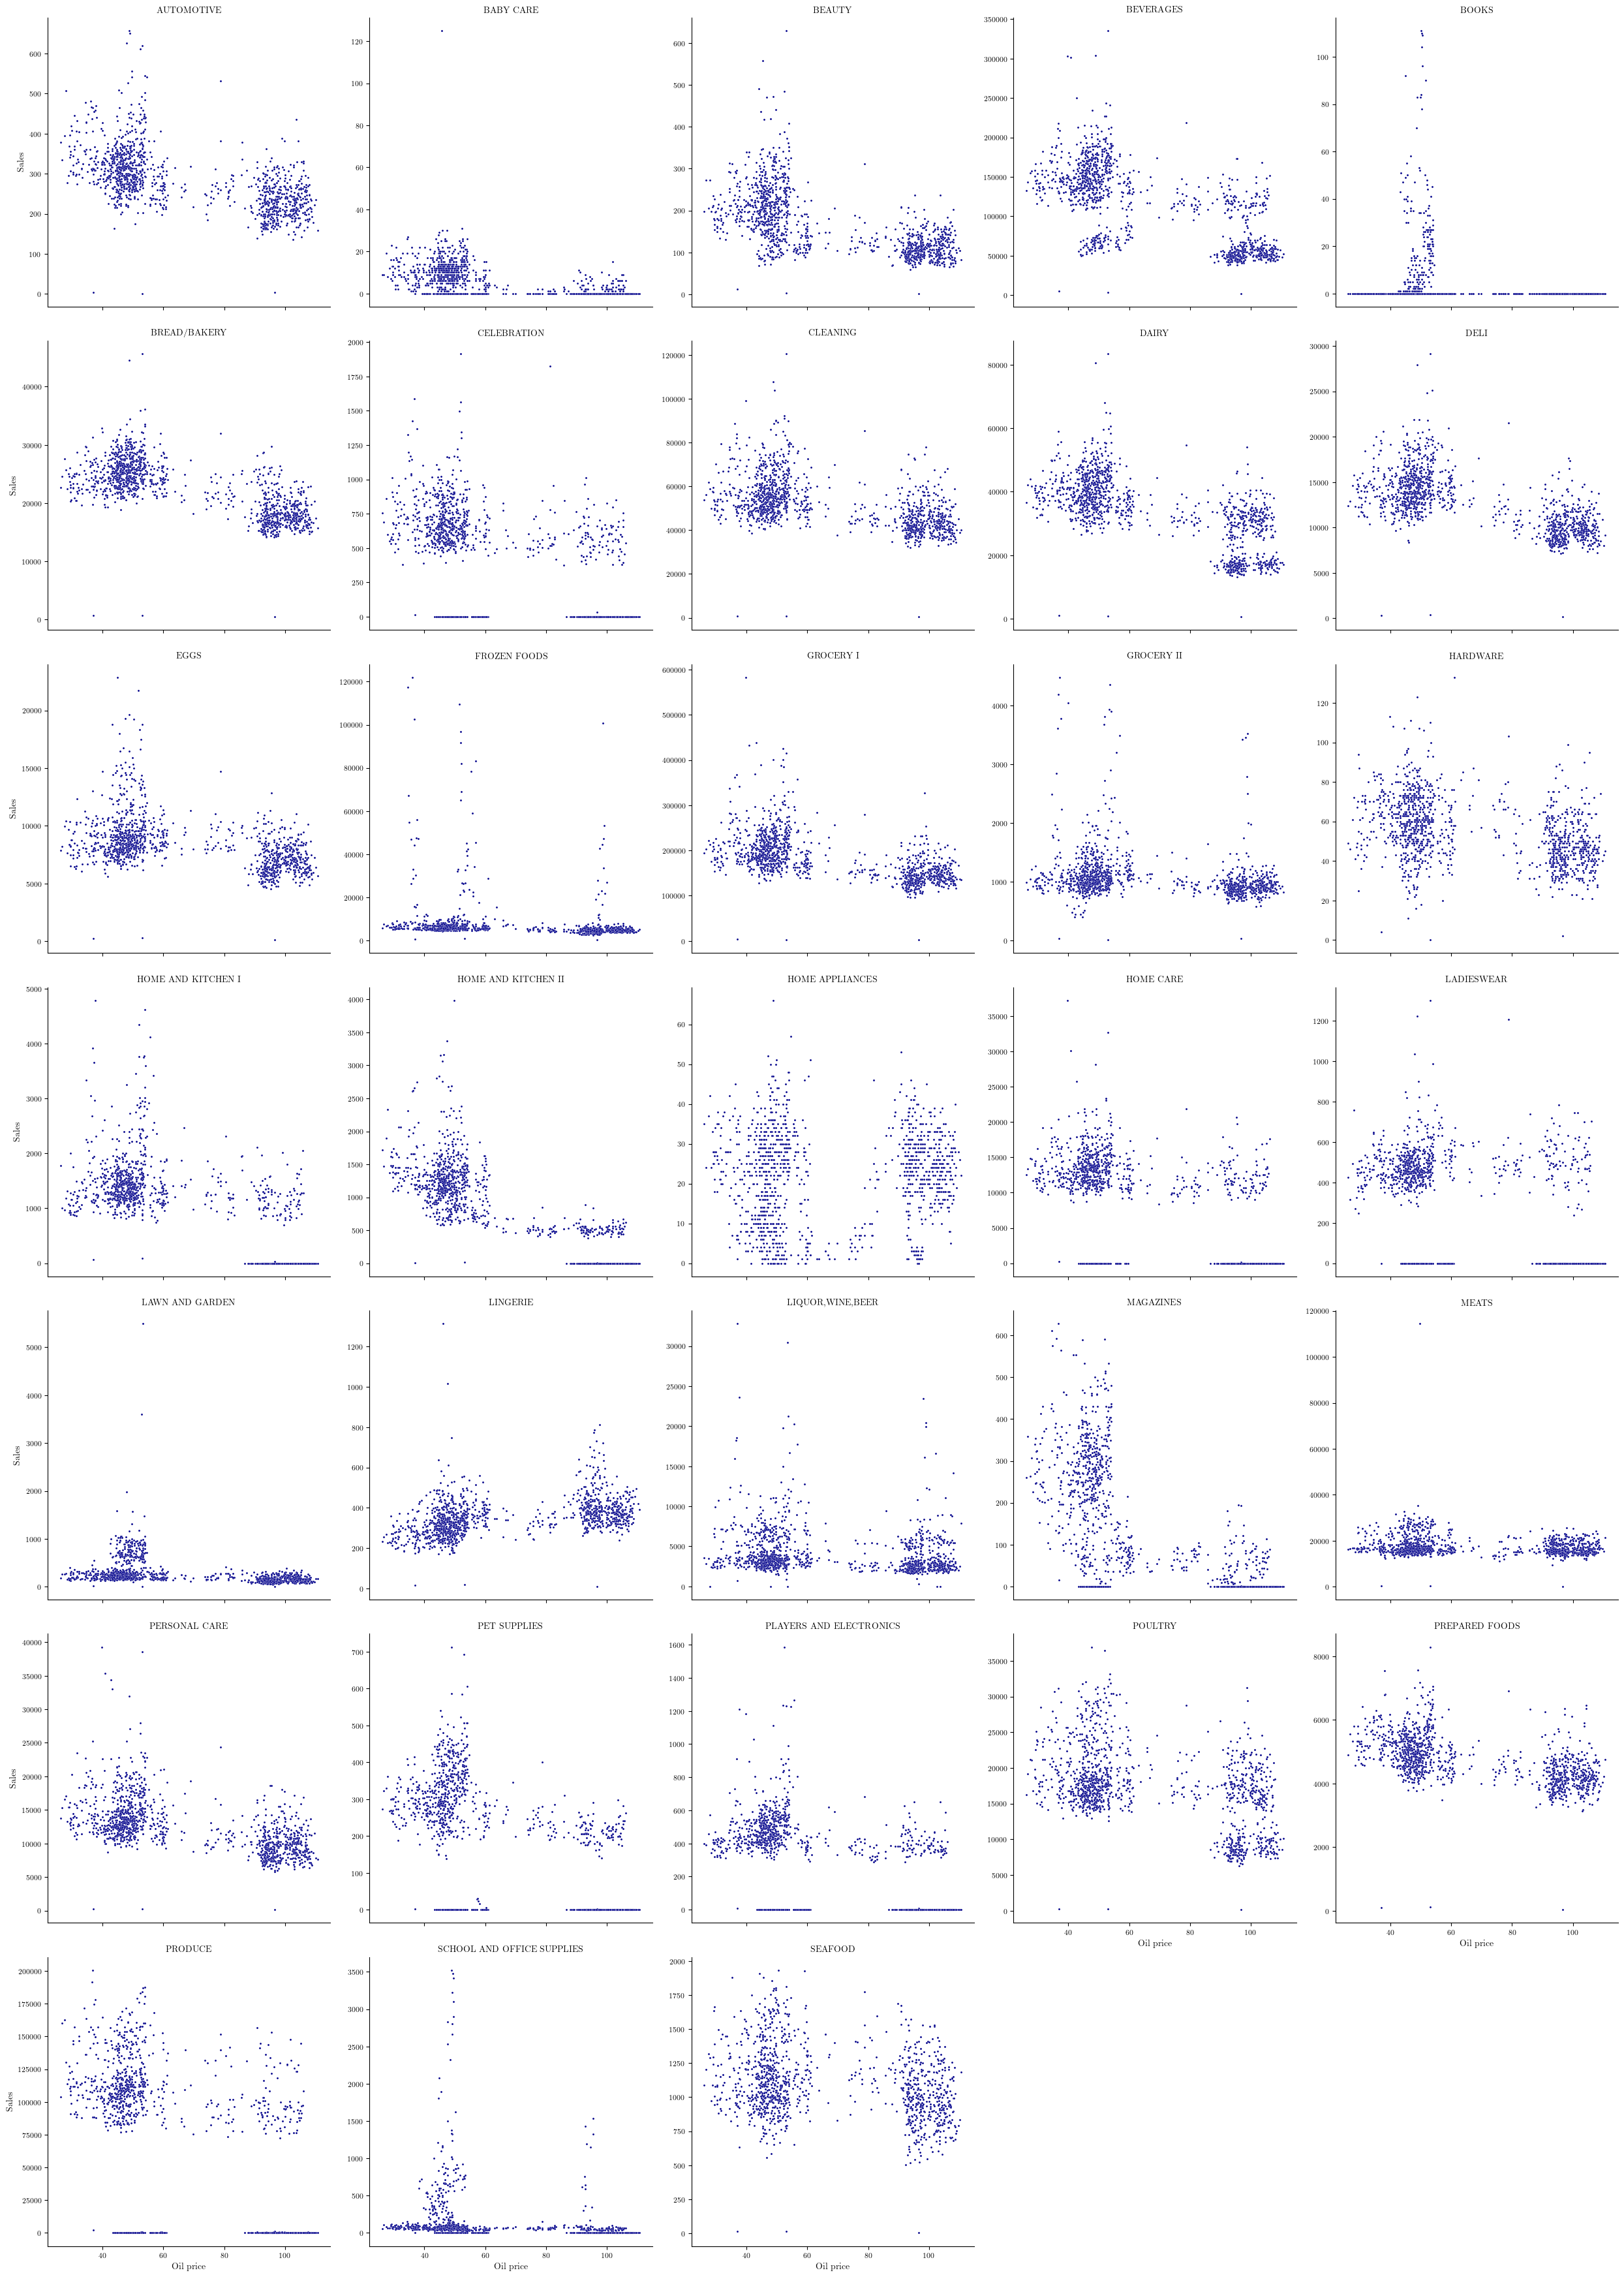

In [57]:
multi_scatter(temp, 'price_oil_interp', 'sales', 'family', 5, r'Oil price', r'Sales', \
              path_plots, 'sales_variations_with_oil_price_per_family.pdf', cm)

#### Sales are usually larger when oil prices are low, but the pattern is usually more complicated. The influence of oil prices varies from product to product

# Seasonal information and lag features

#### It is impossible to test and inspect all the possible time series (54 stores, 33 stores, multiple years). For instance, we can inspect the average sales for each individual product

In [58]:
temp_lag = data.groupby(["date", "family"]).sales.mean().reset_index()#.set_index("date")
average_sales = temp_lag.pivot(index='date', columns='family', values='sales')
average_sales.head()

family      AUTOMOTIVE  BABY CARE    BEAUTY    BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                            
2013-01-01    0.000000        0.0  0.037037    15.000000    0.0      3.344241   
2013-01-02    4.722222        0.0  3.833333  1335.037037    0.0    486.042944   
2013-01-03    2.981481        0.0  2.314815   964.907407    0.0    341.786667   
2013-01-04    3.129630        0.0  2.462963  1003.092593    0.0    309.666093   
2013-01-05    6.333333        0.0  3.537037  1441.074074    0.0    414.217798   

family      CELEBRATION     CLEANING       DAIRY        DELI  ...  MAGAZINES  \
date                                                          ...              
2013-01-01          0.0     3.444444    2.648148    1.316481  ...        0.0   
2013-01-02          0.0  1382.018519  432.981481  291.750000  ...        0.0   
2013-01-03          0.0  1035.055556  333.351852  206.897315  ...        0.0   
2013-01-04          0.0   964.148148  336.074074  187.837204  ...        0.0   
2013-01-05          0.0  1298.666667  427.444444  254.350834  ...        0.0   

family           MEATS  PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  \
date                                                                           
2013-01-01    2.051870       0.462963           0.0                      0.0   
2013-01-02  386.508593     318.592593           0.0                      0.0   
2013-01-03  307.359224     232.740741           0.0                      0.0   
2013-01-04  400.480797     209.314815           0.0                      0.0   
2013-01-05  386.649834     311.462963           0.0                      0.0   

family         POULTRY  PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  \
date                                                                          
2013-01-01    0.789574        0.700870      0.0                         0.0   
2013-01-02  258.812684       98.853925      0.0                         0.0   
2013-01-03  197.673963       66.507185      0.0                         0.0   
2013-01-04  199.491019       82.832704      0.0                         0.0   
2013-01-05  249.537205      107.964315      0.0                         0.0   

family        SEAFOOD  
date                   
2013-01-01   0.000000  
2013-01-02  28.273148  
2013-01-03  20.265018  
2013-01-04  23.946685  
2013-01-05  23.067352  

[5 rows x 33 columns]

In [59]:
def deseason(df, col):
    
    from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
    from sklearn.linear_model import LinearRegression

    # extract column data
    y = df.loc[:,str(col)].copy().resample('1D').ffill() # take into account missing data
    ##print(y.head())
    
    # Use DeterministicProcess and CalendarFourier to create:
    #    indicators for weekly seasons and
    #    Fourier features of order 4 for monthly seasons.

    fourier = CalendarFourier(freq="M", order=4) 

    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
        )

    X = dp.in_sample()
    
    X["week"] = X.index.isocalendar().week
    X["day"] = X.index.dayofweek
    
    #  fit the seasonal model.
    model = LinearRegression().fit(X, y)
    y_pred = pd.Series(
        model.predict(X),
        index=X.index,
        name='Fitted',
        )
    y_pred = pd.Series(model.predict(X), index=X.index)
    
    # get deseasoned data 
    y_deseason = y - y_pred
    
    return y_pred, y_deseason

In [60]:
list_cat = list(average_sales.columns.unique())
n_cat=len(list_cat)
deseasoned = average_sales.copy()
for i in range(len(list_cat)):
    col_pred=str(list_cat[i])+'_pred'
    col_des=str(list_cat[i])+'_des'
    deseasoned[col_pred], deseasoned[col_des] = deseason(deseasoned, list_cat[i])                               

In [61]:
deseasoned['date'] = average_sales.index
deseasoned.reset_index(drop=True, inplace=True)

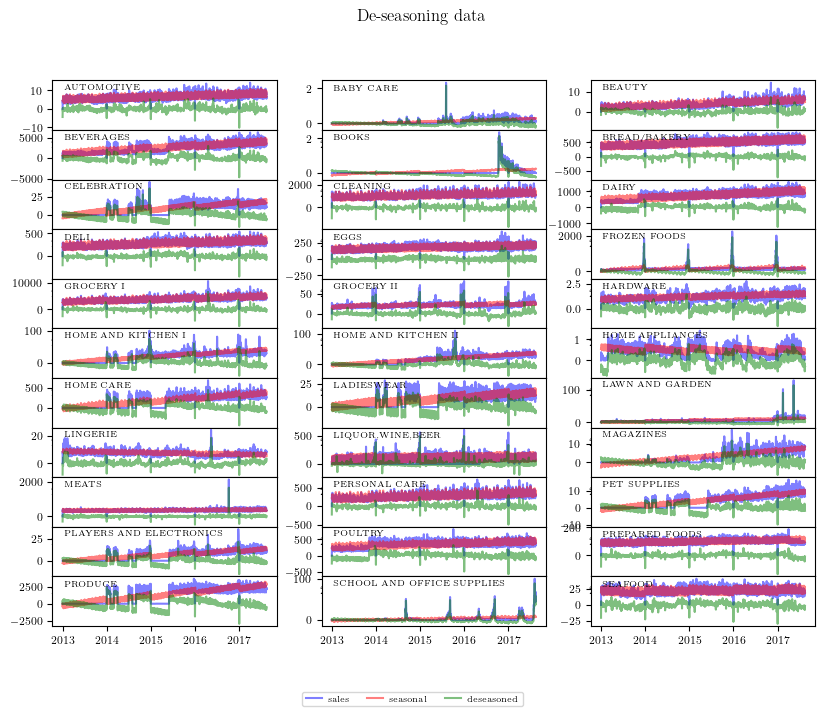

In [62]:
def plot_deseasoning_categorical_sales(df, list_cat, path, filename, cm):

    n_cat=len(list_cat)
    # get the required number of rows given 3 columns
    ncols = 3
    nrows = n_cat // ncols + (n_cat % ncols > 0)

    fig = plt.figure(figsize=(25*cm, 18*cm))
    fig.subplots_adjust(hspace=0.)
    fig.suptitle('De-seasoning data')

    colx = 'date'
    for n, cat in enumerate(list_cat):
        # cols to plot
        coly1 = str(cat)
        coly2 = str(cat+'_pred')
        coly3 = str(cat+'_des')
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)
        axa = ax.plot(df[colx], df[coly1], color='blue', alpha=0.5, label='sales')
        axb = ax.plot(df[colx], df[coly2], color='red', alpha=0.5, label='seasonal')
        axc = ax.plot(df[colx], df[coly3], color='green', alpha=0.5, label='deseasoned')
        ax.annotate(cat, xy=(0.05,0.8), xycoords='axes fraction', fontsize='xx-small')
 
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)

    file = path / str(filename)
    fig.savefig(file, format='pdf')

plot_deseasoning_categorical_sales(deseasoned, list_cat, path_plots, 'Deseasoning_categorical data.pdf', cm)        

#### It is clear from these plots that not all categories show strong seasonal features, meaning that that de-seasoning actually makes the input worse for those. A good way to investigate seasonal trends is to inspect a periodogram

In [63]:
def get_periodogram(ts, detrend='linear', ax=None):
    
    from scipy.signal import periodogram
    
    '''
    ts: time serie(s)
    fs: sampling frequency(ies) of the ts time serie(s)
    Here fs is determined locally from the formula below
    '''
    
    ###
    # sklearn expects floating point values, not date_time values
    ###
        
    #fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    fs = 365.2425
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    return frequencies, spectrum

def plot_periodogram(fq, sp, list_cat, path, filename, cm):
    
    import math
    
    n_cat=len(list_cat)

    i,j=0,0
    plots_per_row=3
    nrows = math.ceil(len(list_cat)/plots_per_row)
    
    fig = plt.figure(figsize=(28*cm, 18*cm))
    fig, ax = plt.subplots(nrows,plots_per_row)
    fig.suptitle('Periodograms')

    for n, cat in enumerate(list_cat):
        ax[i][j].step(fq[cat], sp[cat], color="purple")
        ax[i][j].set_xscale("log")
        ax[i][j].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        ax[i][j].tick_params(axis='y', labelsize='xx-small')
        ax[i][j].annotate(cat, xy=(0.05,0.7), xycoords='axes fraction', fontsize='xx-small')

        if i==(nrows-1):
                ax[i][j].set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
                ax[i][j].set_xticklabels(
            [
            r'Annual (1)',
            r'Semiannual (2)',
            r'Quarterly (4)',
            r'Bimonthly (6)',
            r'Monthly (12)',
            r'Biweekly (26)',
            r'Weekly (52)',
            r'Semiweekly (104)',
            ],
            rotation=90, fontsize='xx-small',
            )
        ##if j==0:
        ##    ax[i][j].set_ylabel(r'Variance', fontsize='xx-small')
        
        # adjust loop indices
        j+=1
        if j%plots_per_row==0:
            i+=1
            j=0

    file = path / str(filename)
    fig.savefig(file, format='pdf')

<Figure size 1102.36x708.661 with 0 Axes>

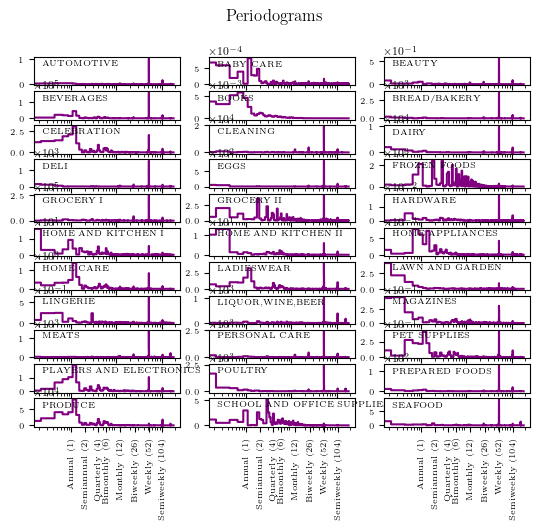

In [64]:
fq = pd.DataFrame()
sp = pd.DataFrame()

for n, cat in enumerate(list_cat):
    ts=average_sales[cat]
    fq[cat], sp[cat] = get_periodogram(ts, detrend='linear', ax=0) 
plot_periodogram(fq, sp, list_cat, path_plots, 'Sales_periodogram_per_category.pdf', cm)

#### A large fraction (but not all) of the categories show a weekly seasonal trend. Some show a slight bi-weekly or monthly trend. a good number of categories show a yearly trend

#### LAG FEATURES

Lagged timeseries are necessary to investigate serial dependences (e.g., cycles) in a given time series.
Lagged series are copies of the input series shifted by 1, 2, ... n time steps

Autocorrelation and partial autocorrelation are useful to investigate serial dependence
- Autocorrelation computes the correlation of a given time series with (one of) its lags
- Information might be recursively passed to the next lag, so not all lags are equally useful
- Partial autocorrelation allows to select which lags should be accounted for, as it only evaluates the amount of new informtion brought by lag n that was not already embedded in the n-1 previous lags

In [65]:
def plot_ACF_PACF(df, path, filename, cm):
    
    # uses plot_acf, plot_pacf from statsmodels
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

    list_cat = list(average_sales.columns.unique())
    for n, cat in enumerate(list_cat):
        try:
            fig, ax = plt.subplots(1,2, figsize=(38*cm, 12.7*cm))
            # Autocorrelation
            sm.graphics.tsa.plot_acf(df[cat], lags=365, ax=ax[0], \
                                     title = "AUTOCORRELATION\n" + str(cat).title(), \
                                     vlines_kwargs={'color': 'dodgerblue', 'lw':1},)
            
            # Partial autocorrelation
            sm.graphics.tsa.plot_pacf(df[cat], lags=365, method='ywm', ax=ax[1], \
                                      title = "PARTIAL AUTOCORRELATION\n" + str(cat).title(), \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})
            
            # insert plot showing the first 12 Lags features for PACF
            axins = inset_axes(ax[1], width="45%", height="30%", loc= 'upper right', bbox_to_anchor=None, borderpad=1)
            sm.graphics.tsa.plot_pacf(df[cat], lags=12, method='ywm', ax=axins, title = None, \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})
        except:
            pass
    
    file = path / str(filename)
    save_multi_image(file)
    
    plt.close()

#### As shown in the plots below, most of the information lies in the first few lags. In some cases, monthly/yearly information (lags=30, 365) may also provide additional information

/tmp/ipykernel_303737/2126149701.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2, figsize=(38*cm, 12.7*cm))


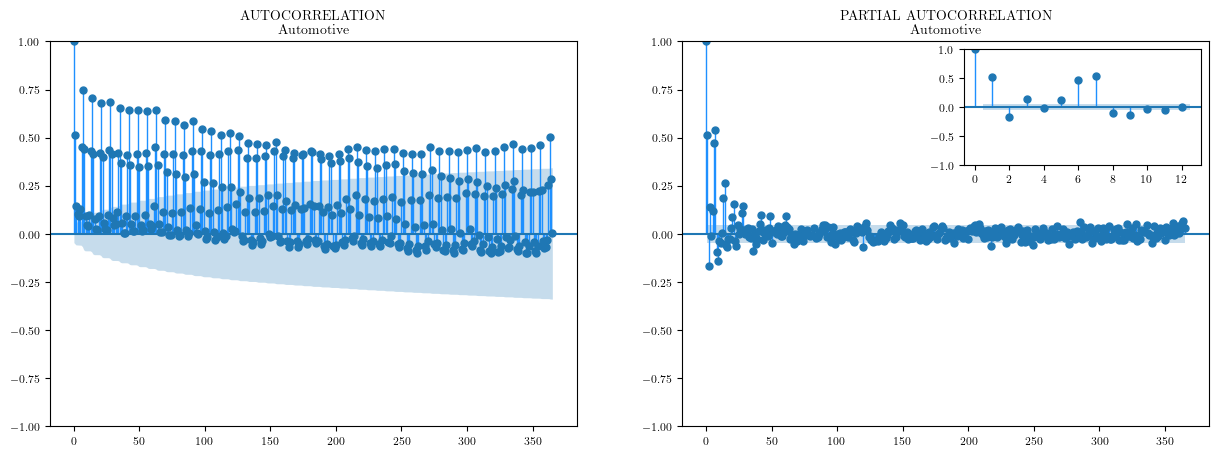

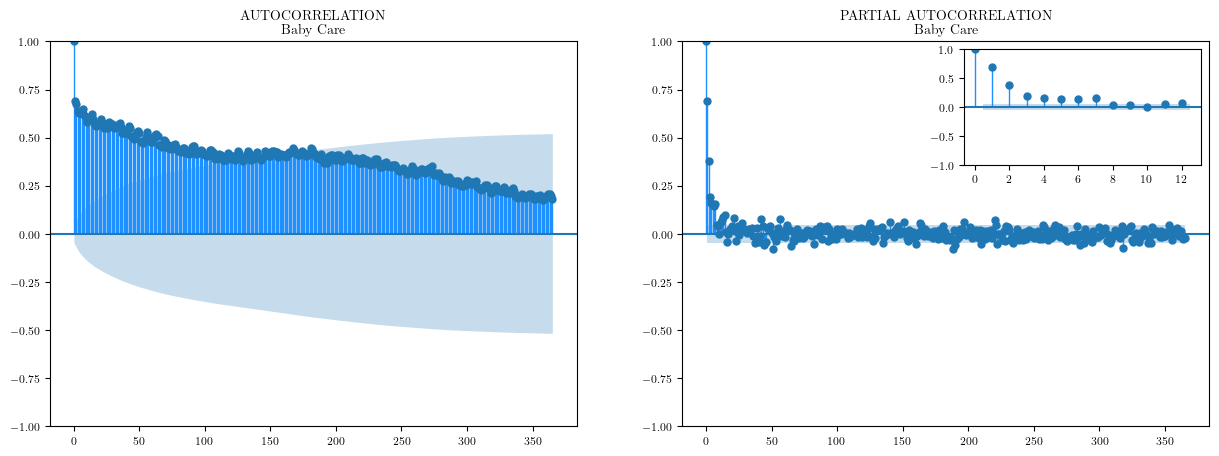

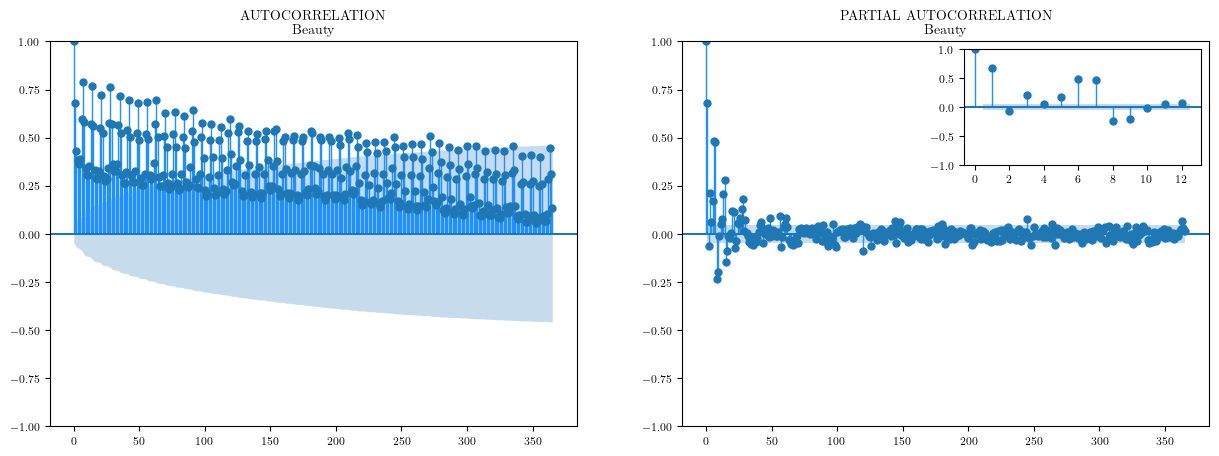

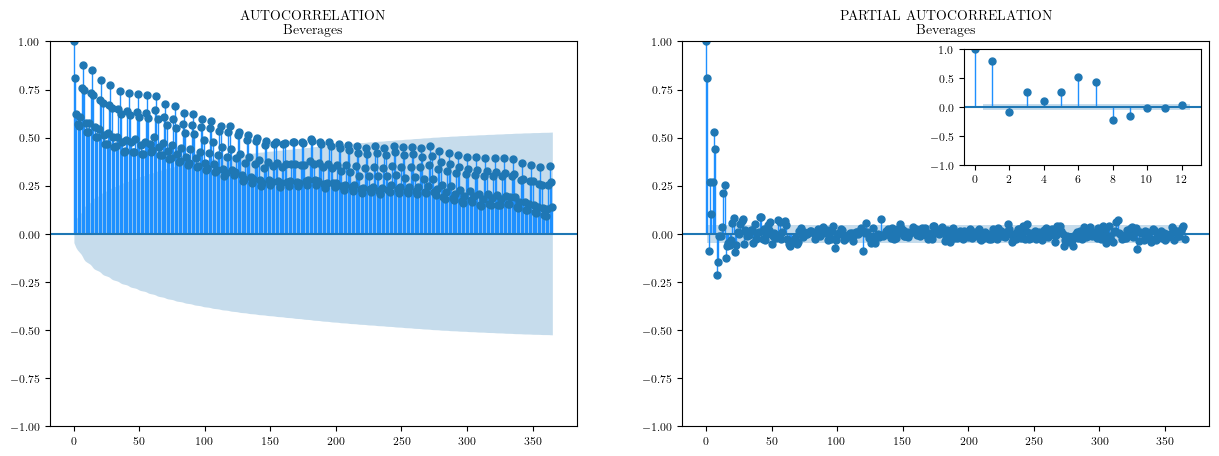

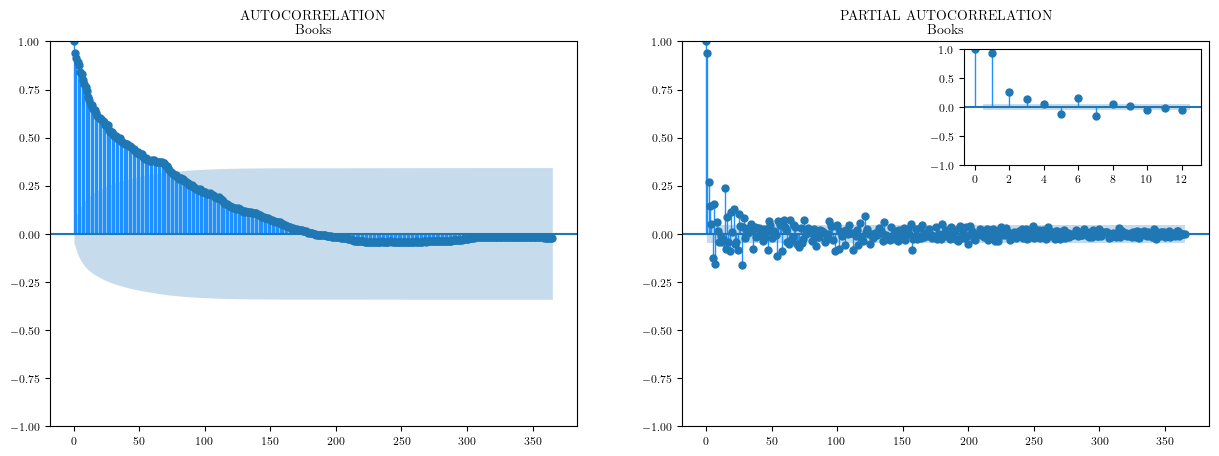

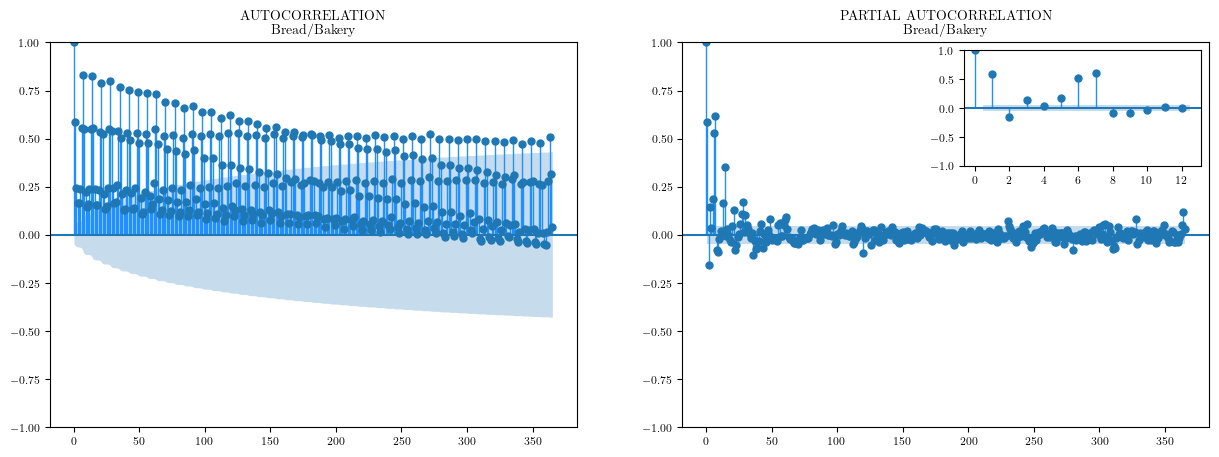

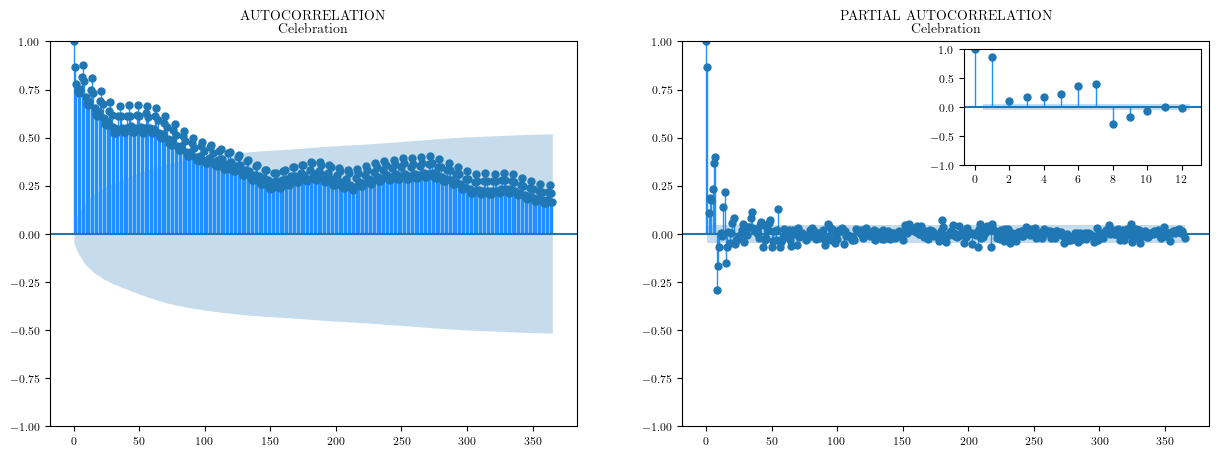

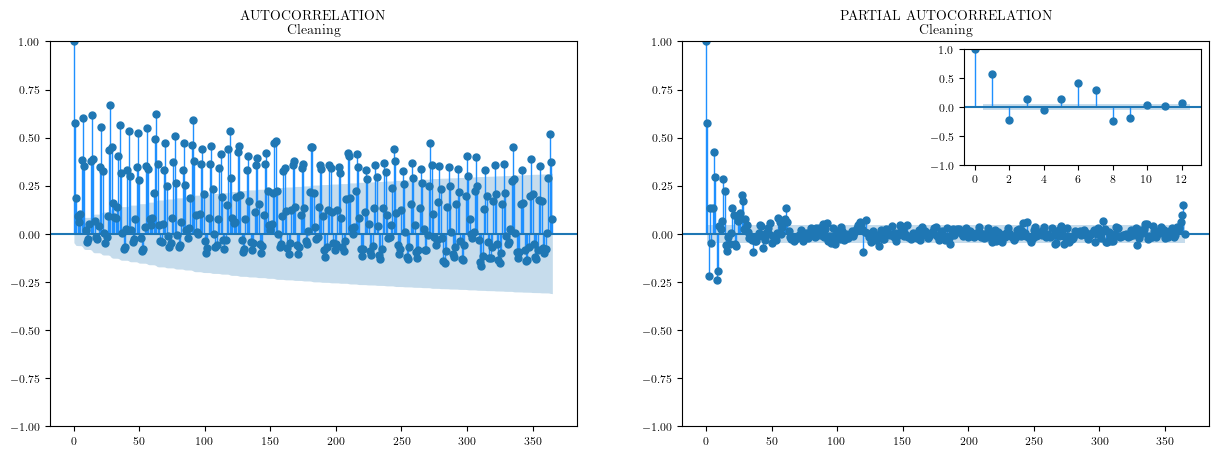

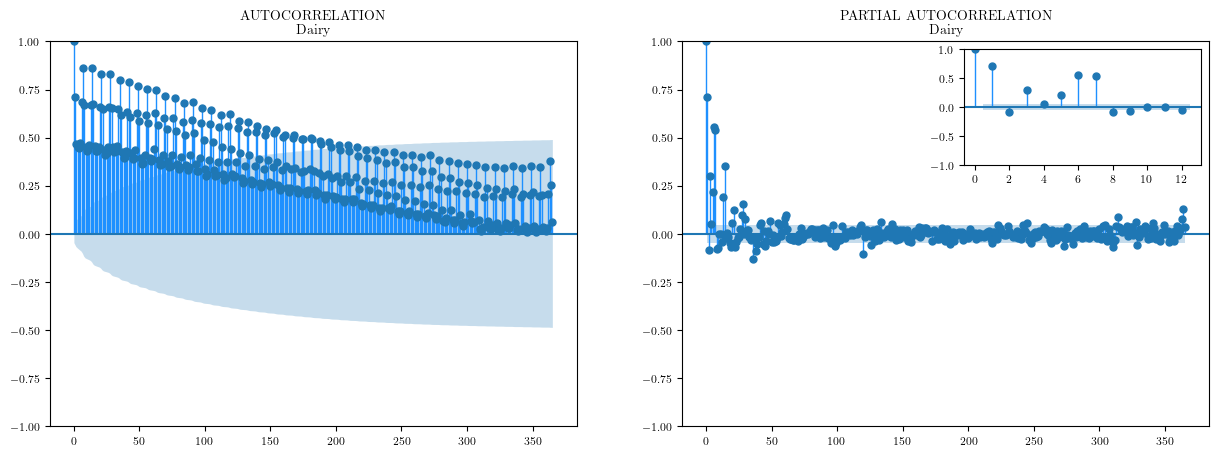

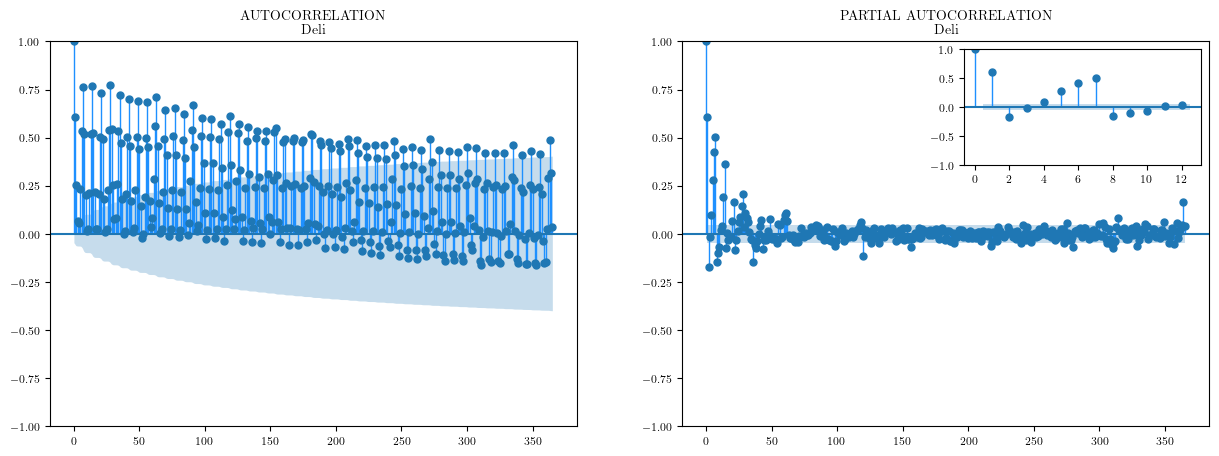

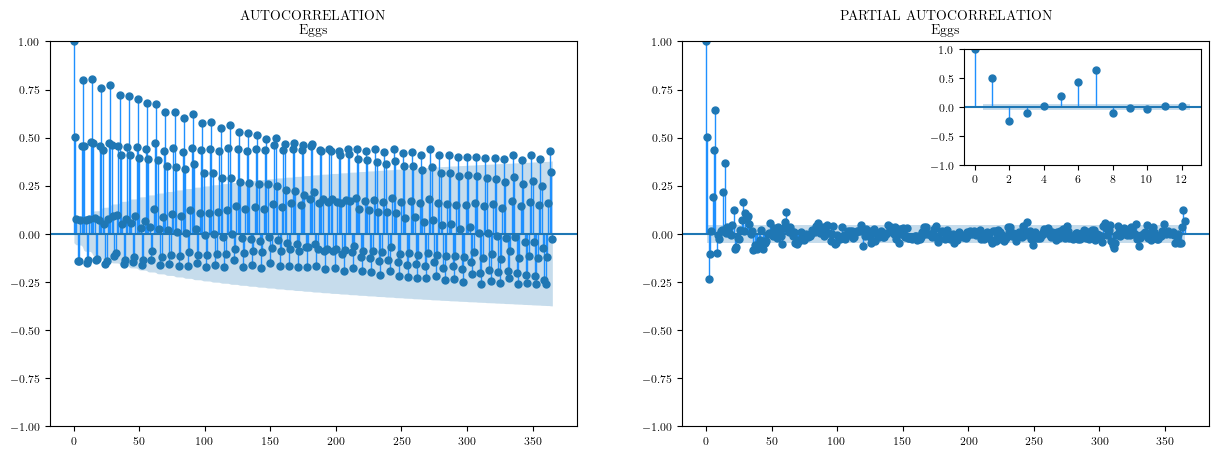

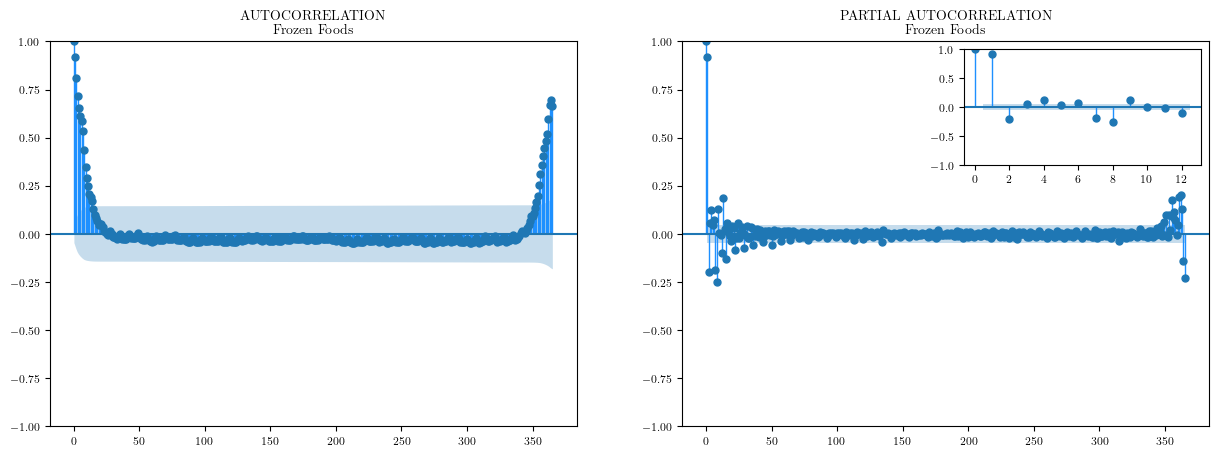

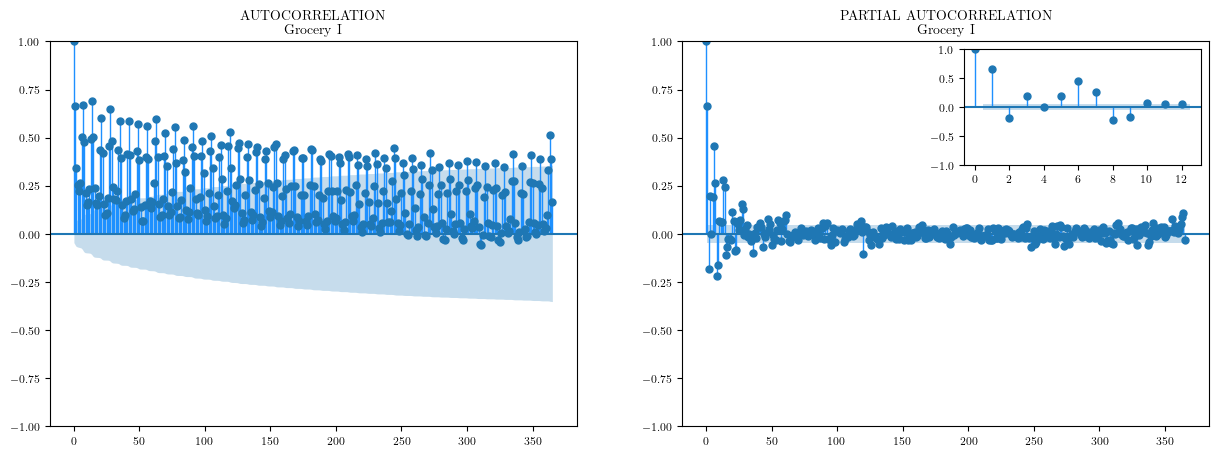

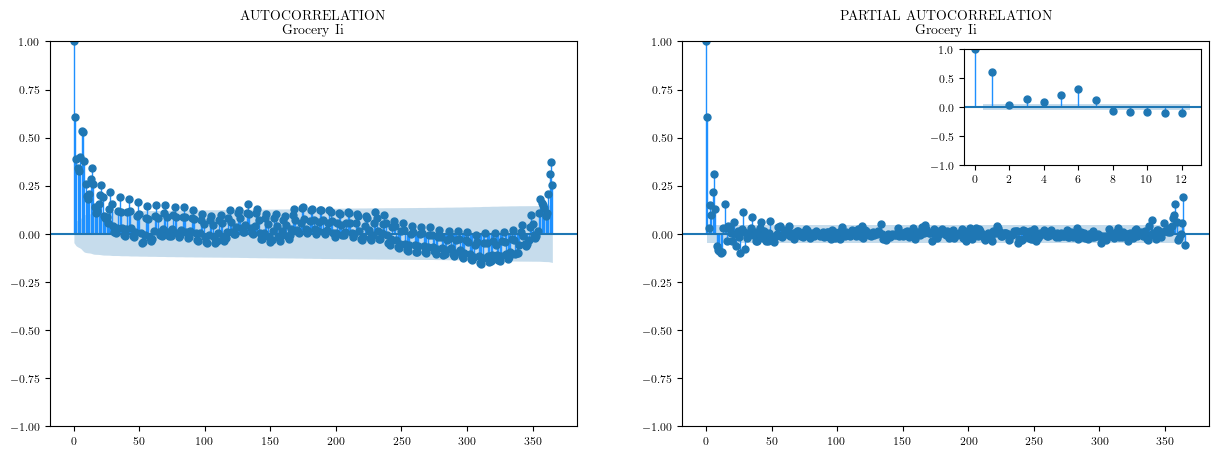

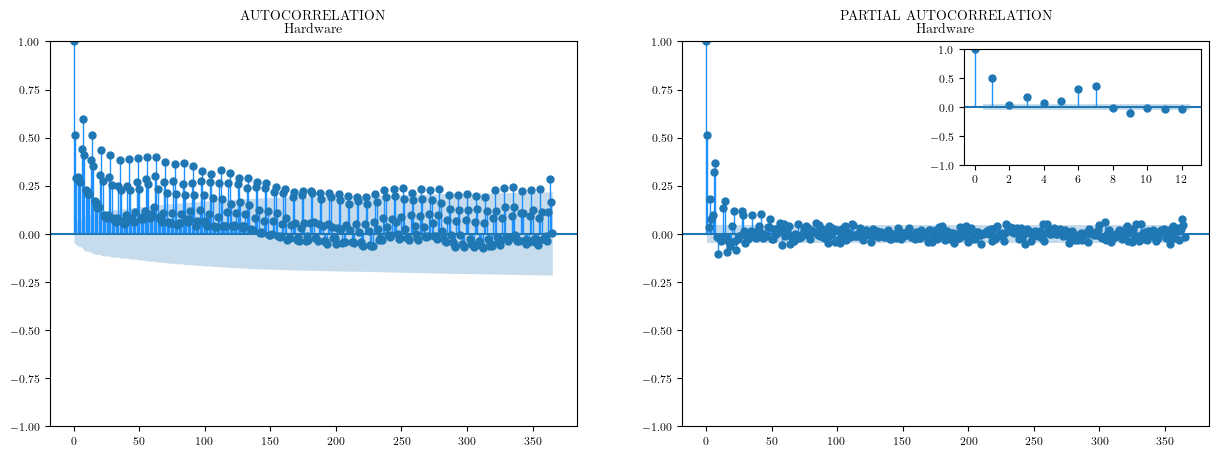

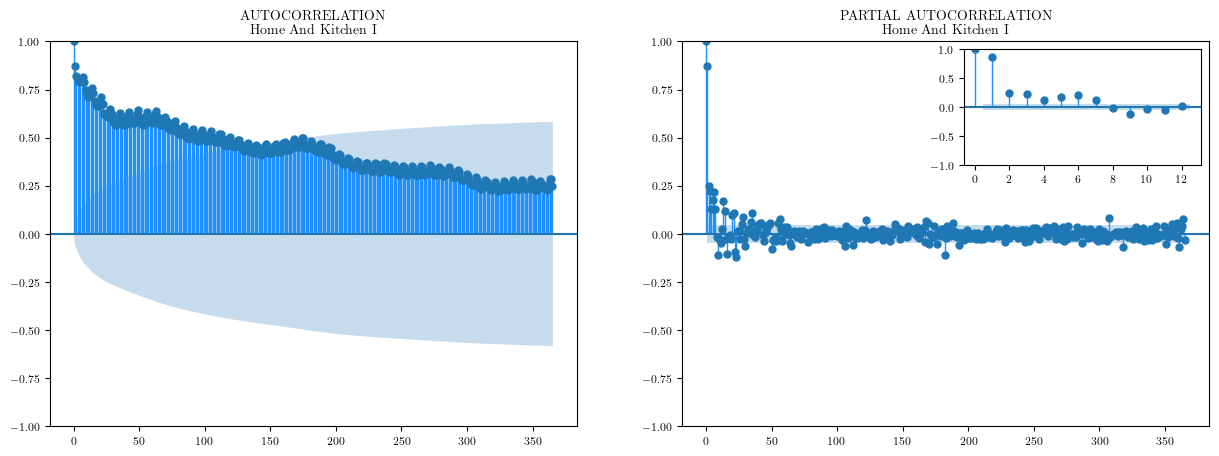

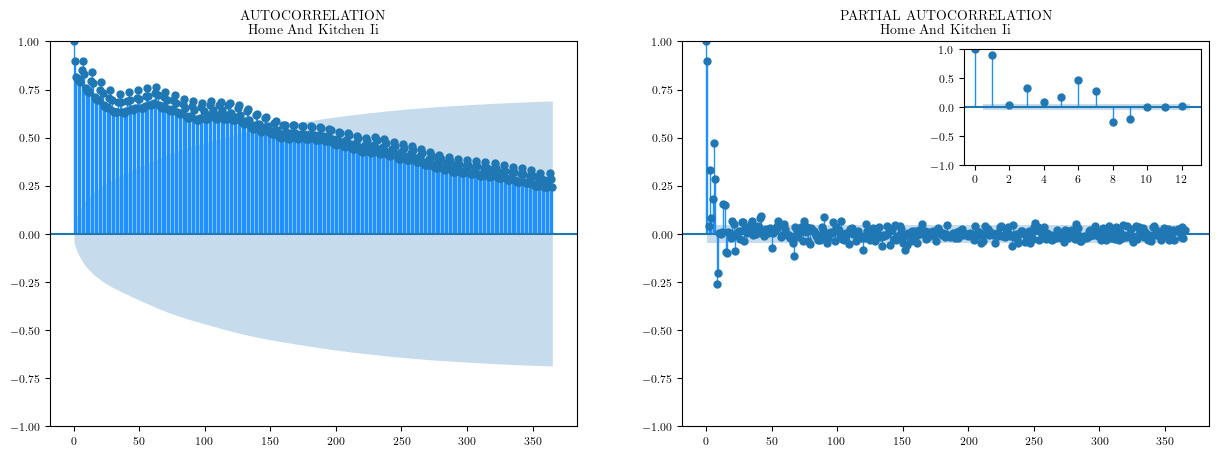

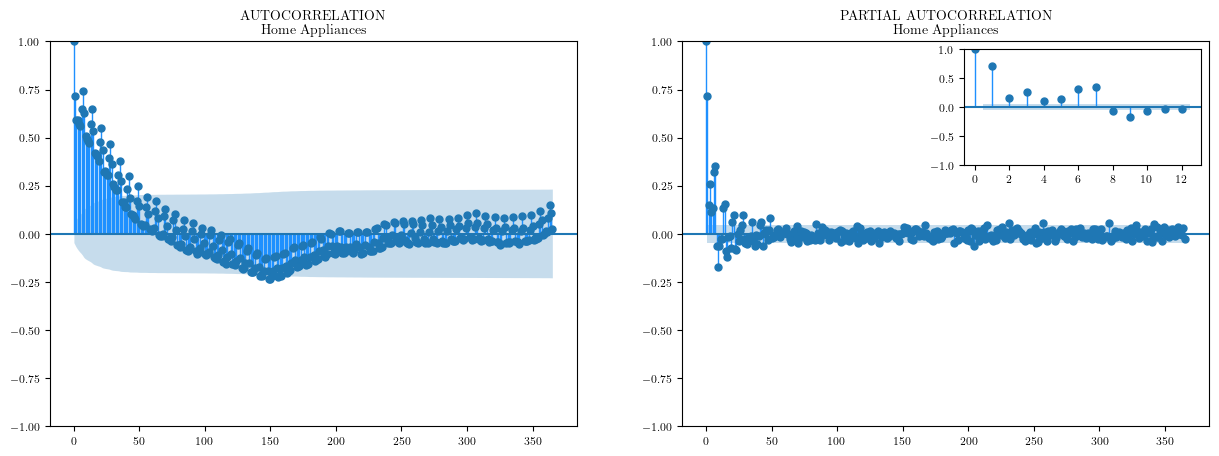

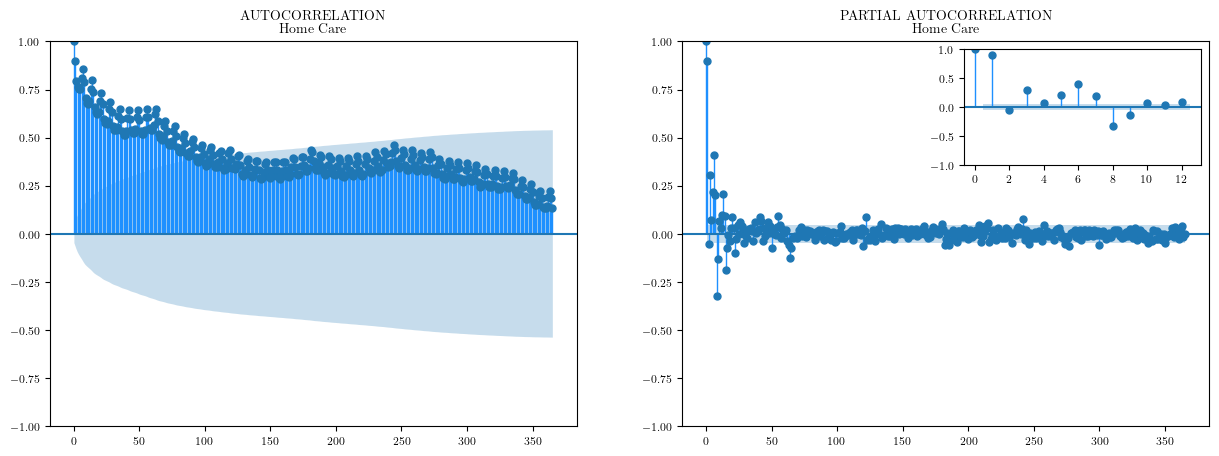

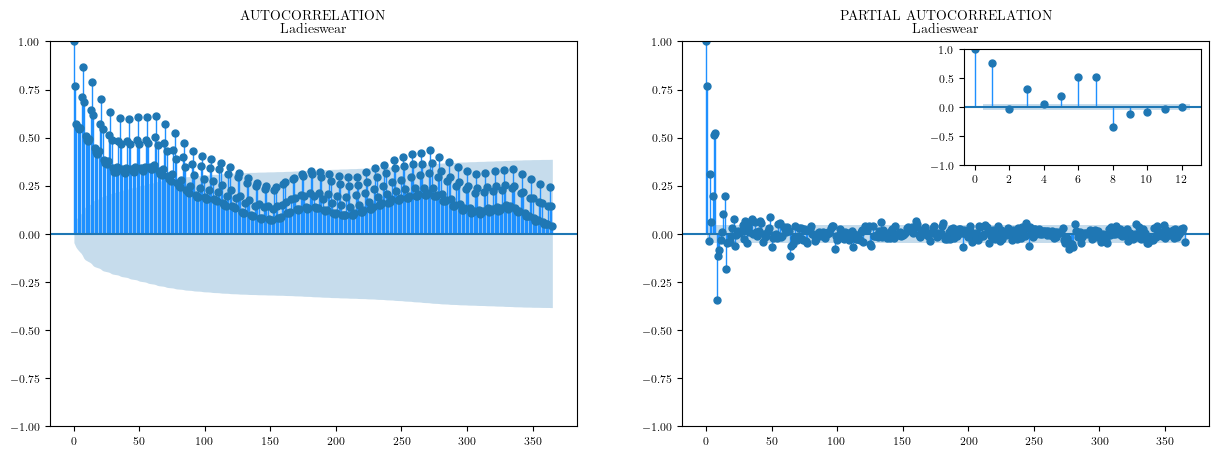

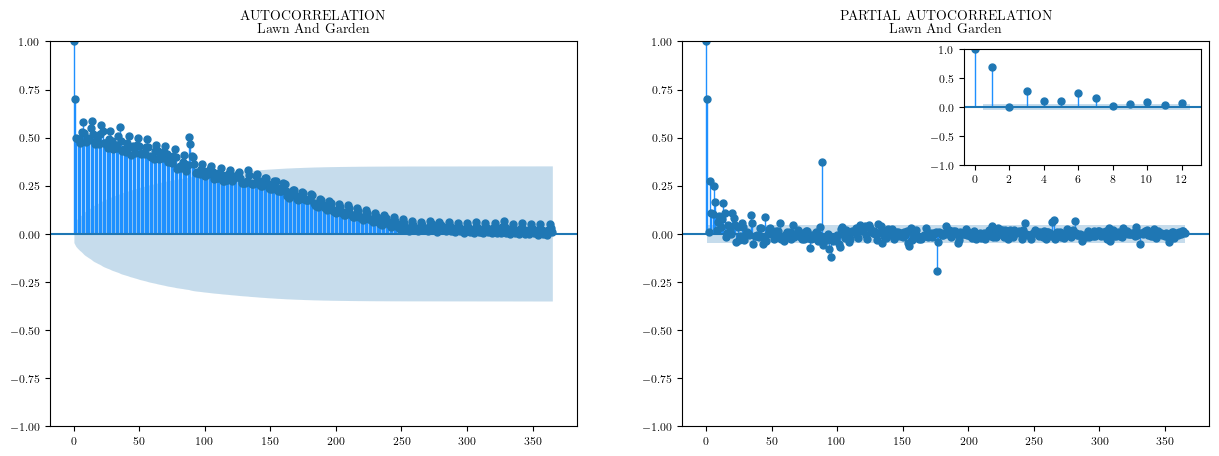

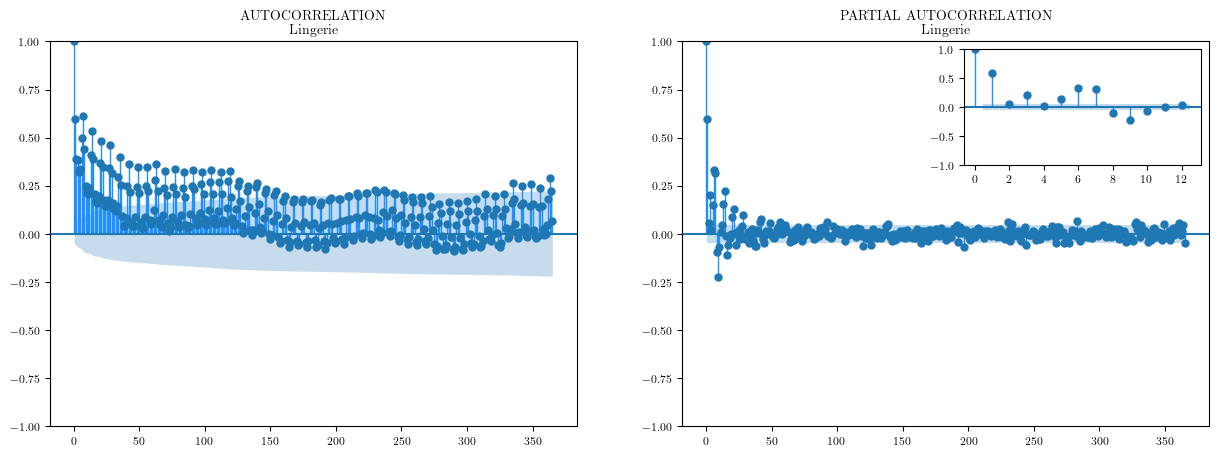

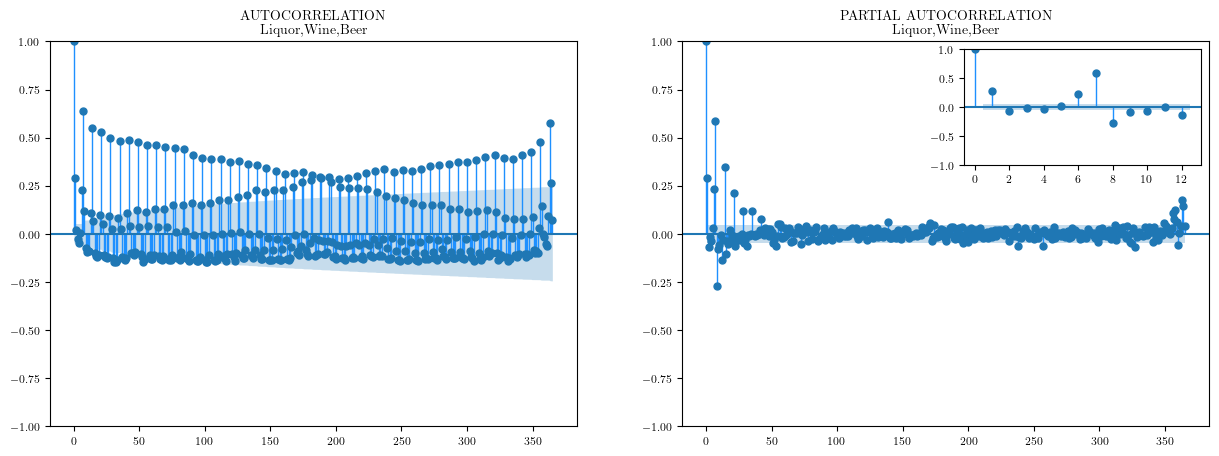

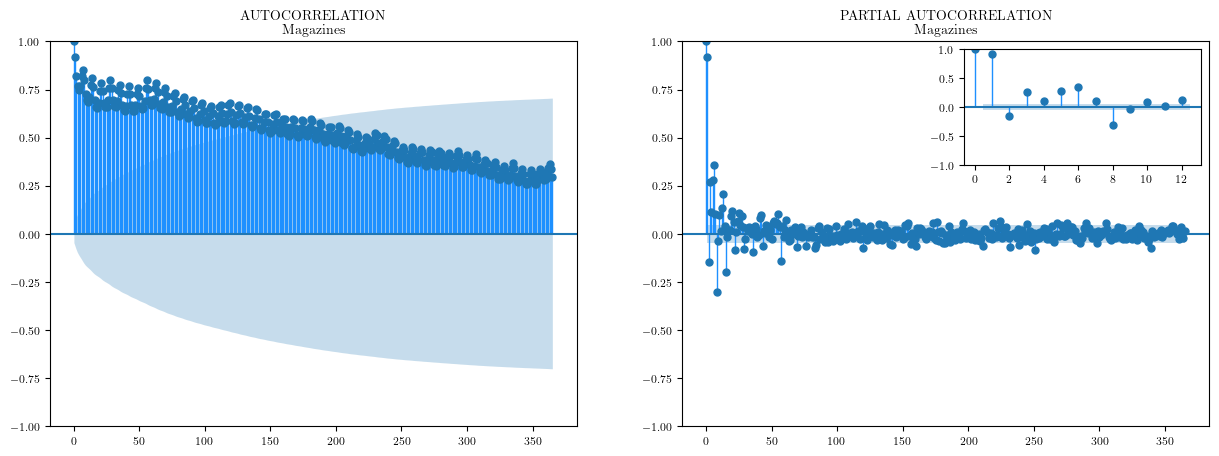

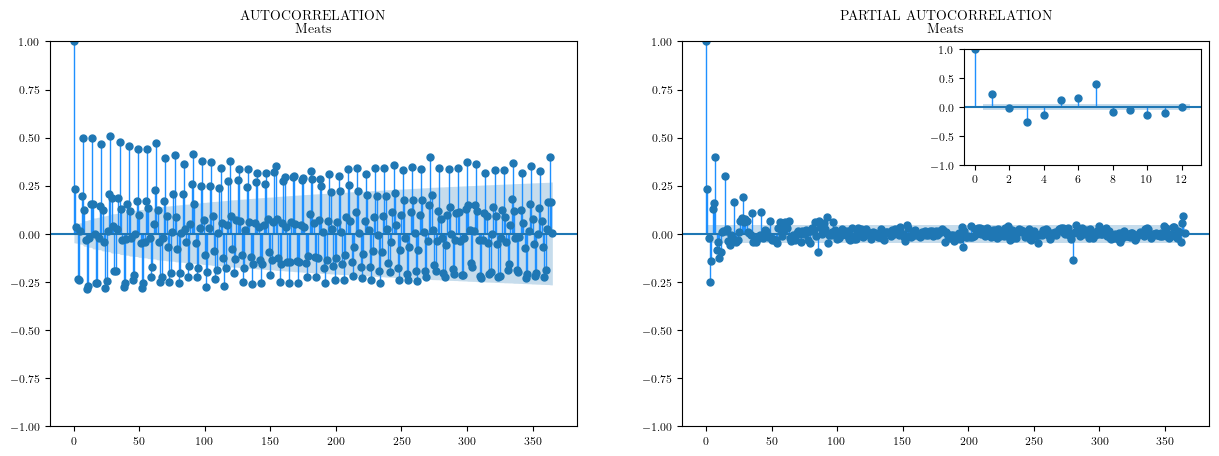

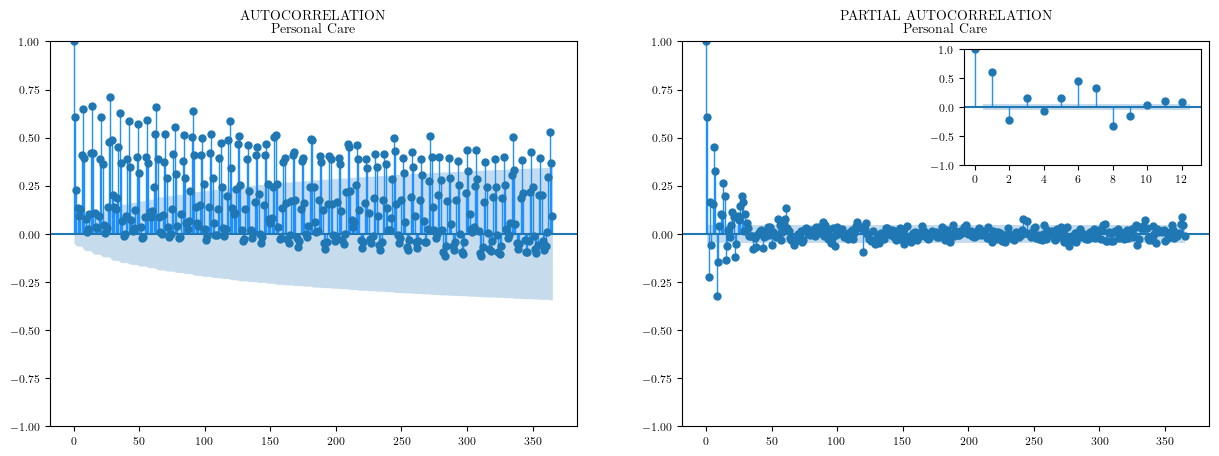

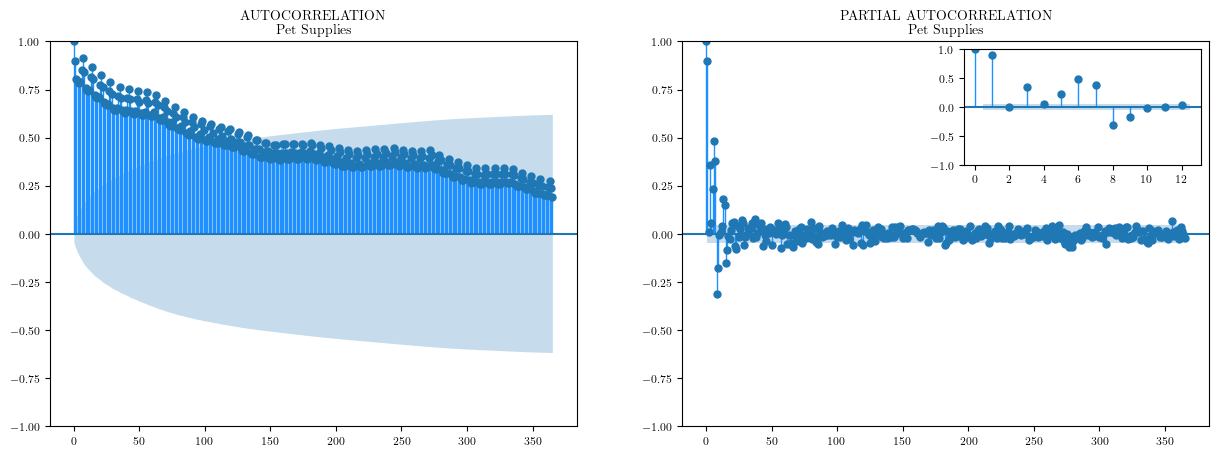

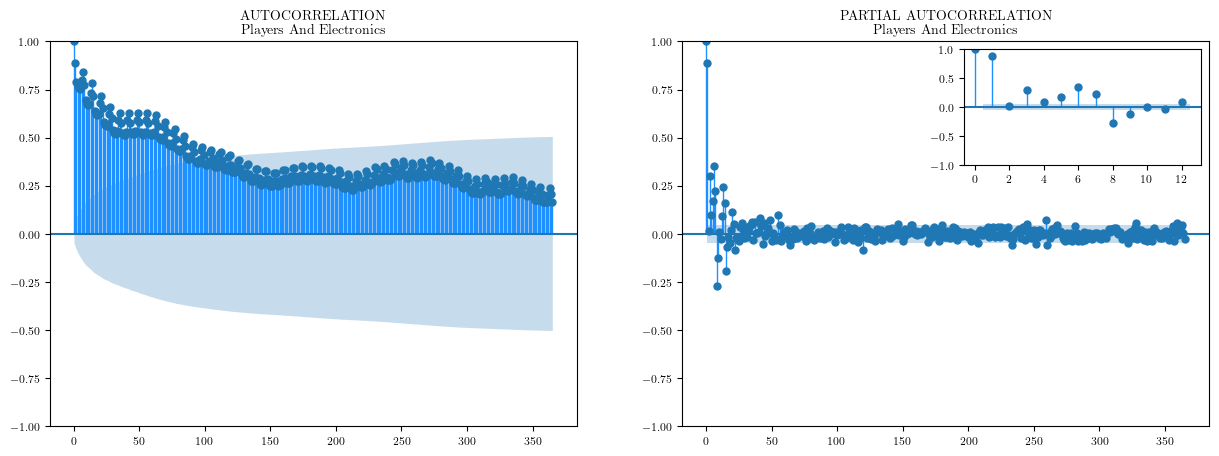

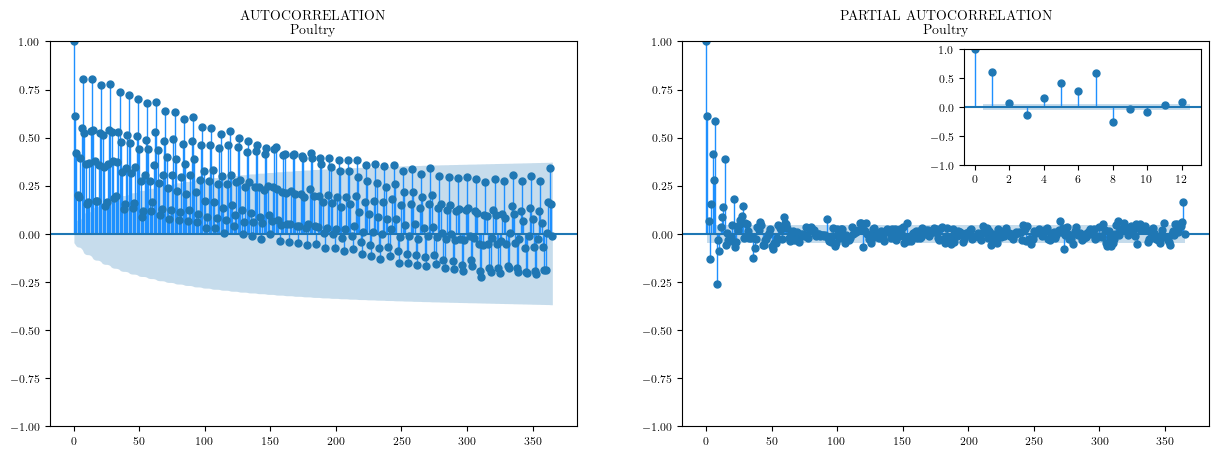

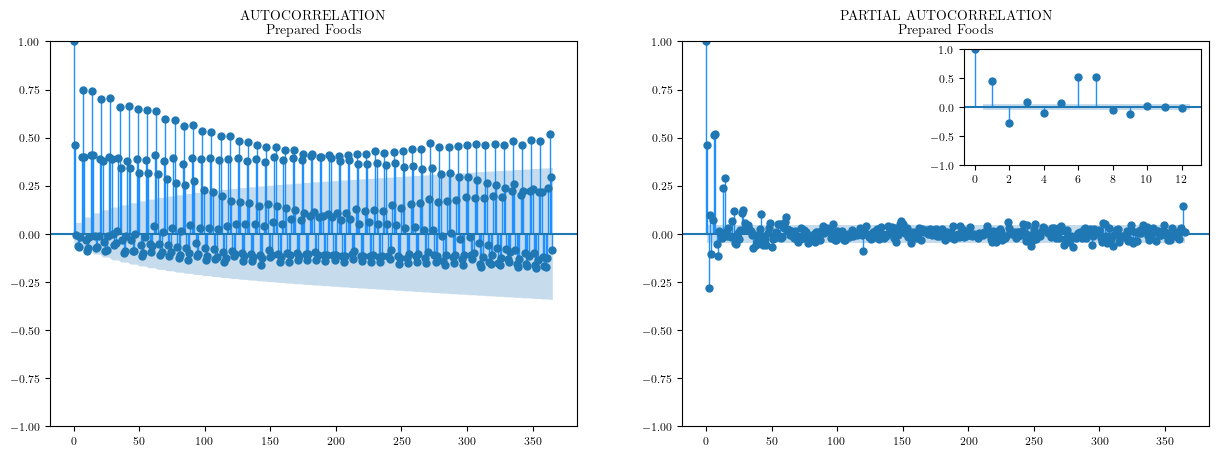

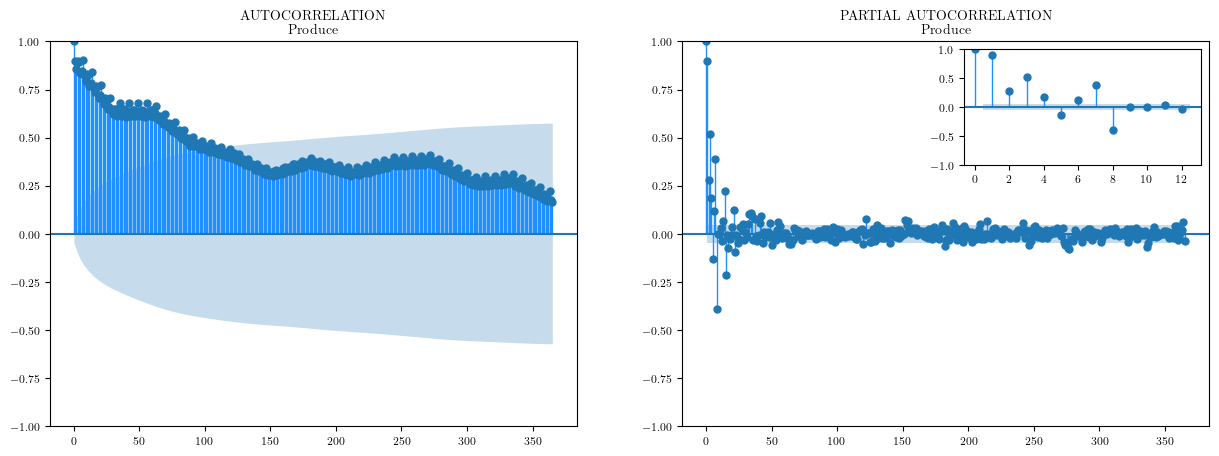

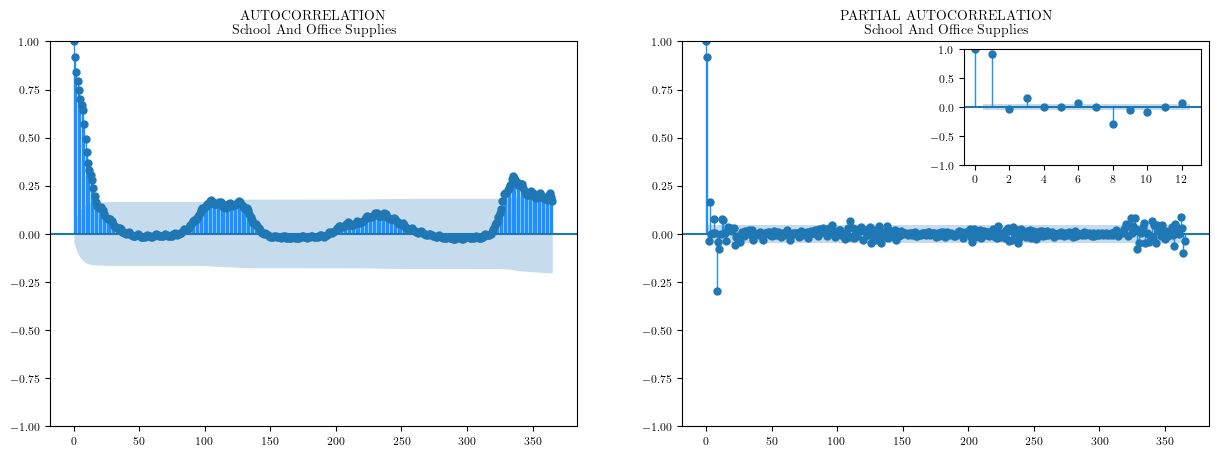

In [66]:
plot_ACF_PACF(average_sales, path_plots, 'average_sales_per_category_(P)ACF.pdf', cm)

In [67]:
# TBD check where sales are 0

In [68]:
# Did Earhquake affect the store sales